In [29]:
# for webscraping
import os 
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time 
import sys
import numpy as np
import pandas as pd 
import regex as re 
import requests
import lxml
from lxml.html.soupparser import fromstring
import prettify
import numbers 
import htmltext

# for visuals using geopandas
from shapely.geometry import Point, Polygon 
import geopandas as gpd
import descartes
import haversine as hs
import folium

# for plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import norm 
import scipy.stats as stats
from matplotlib.font_manager import FontProperties
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import tilemapbase
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
import adjustText as aT
import shapely.speedups
shapely.speedups.enable()

# for stats (min,max,mean)
import statistics
from numpy import mean
from numpy import std 

# statsmodel
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor


# sklearn
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
df = pd.read_csv('data_pred5')
df_norm = pd.read_csv('df_norm_final')
df_quantile = pd.read_csv('df_processed_quantile')

# Model 1

In this first model I will explore the orginal features that account for the homes that were sold within the years 2014 and 2015. Due to the objective of the buisness problem being solve we targeted only homes that fall within 1.5 standard deviation of the price mean. This decision was made when evaluating the median house hold income in 2015, which was about 81,000. 


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 24 columns):
price                           18109 non-null float64
bathrooms                       18109 non-null float64
sqft_lot                        18109 non-null int64
sqft_living                     18109 non-null int64
waterfront                      18109 non-null float64
grade                           18109 non-null int64
zipcode                         18109 non-null int64
lat                             18109 non-null float64
long                            18109 non-null float64
district                        18109 non-null object
grades                          18109 non-null object
grade_rank                      18109 non-null int64
coor                            18109 non-null object
School_K_12                     18109 non-null float64
School_Junior_High_Middle       18109 non-null float64
School_Elementary               18109 non-null float64
dist_School_High        

When examining the initial dataset I dove deeper to understand the relationship between all the columns to price. I have determined the following columns have the strongest relationship to price so I will use these to establish my first model using the following features. 

1. bathrooms
2. sqft_lot
3. sqft_living
5. waterfront
4. grade

In [8]:
target_value1 = ['price','bathrooms','sqft_lot','sqft_living','waterfront','grade']

In [9]:
df_model1 = df[target_value1]

In [10]:
df_model1

price  bathrooms  sqft_lot  sqft_living  waterfront  grade
0      538000.0       2.25      7242         2570         0.0      7
1      180000.0       1.00     10000          770         0.0      6
2      604000.0       3.00      5000         1960         0.0      7
3      510000.0       2.00      8080         1680         0.0      8
4      257500.0       2.25      6819         1715         0.0      7
...         ...        ...       ...          ...         ...    ...
18104  475000.0       2.50      1294         1310         0.0      8
18105  360000.0       2.50      1131         1530         0.0      8
18106  400000.0       2.50      5813         2310         0.0      8
18107  402101.0       0.75      1350         1020         0.0      7
18108  325000.0       0.75      1076         1020         0.0      7

[18109 rows x 6 columns]

In [11]:
# Creating dummy variables for my categorical variables
waterfront_dummy = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
grade_dummy = pd.get_dummies(df.grade, prefix='grade', drop_first=True)

# add these new dummy variables into the df
df_model1 = pd.concat([df_model1, waterfront_dummy, grade_dummy], axis=1)
# delete the categorical variables, they are already being represented by the dummy variables
df_model1= df_model1.drop(['waterfront', 'grade'], axis=1)


In [13]:
df_model1.columns = df_model1.columns.str.replace('.', '_')
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 14 columns):
price             18109 non-null float64
bathrooms         18109 non-null float64
sqft_lot          18109 non-null int64
sqft_living       18109 non-null int64
waterfront_1_0    18109 non-null uint8
grade_4           18109 non-null uint8
grade_5           18109 non-null uint8
grade_6           18109 non-null uint8
grade_7           18109 non-null uint8
grade_8           18109 non-null uint8
grade_9           18109 non-null uint8
grade_10          18109 non-null uint8
grade_11          18109 non-null uint8
grade_12          18109 non-null uint8
dtypes: float64(2), int64(2), uint8(10)
memory usage: 742.9 KB


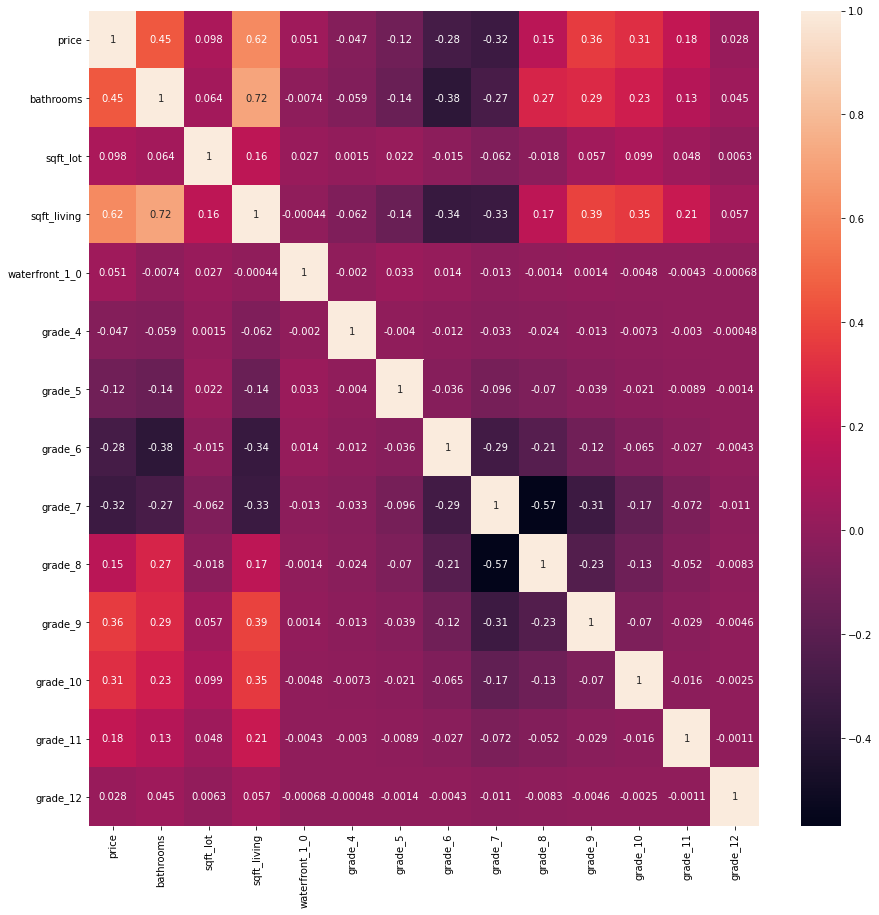

In [15]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model1.corr(),annot=True)

In [16]:
def correlation(dataframe):
    df= dataframe.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    df['pairs'] = list(zip(df.level_0, df.level_1))
    
    df.set_index(['pairs'], inplace= True)
    
    df.drop(columns=['level_1', 'level_0'], inplace= True)
    
    df.columns= ['cc']
    
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc> .75) & (df.cc< 1)]

In [17]:
correlation(df_model1)

Empty DataFrame
Columns: [cc]
Index: []

In [20]:
train, test = train_test_split(df_model1)
print(len(train), len(test))

13581 4528


In [25]:
outcome = 'price'
x_cols = list(df_model1.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model1 = ols(formula=formula, data=train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     1017.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:06:58   Log-Likelihood:            -1.8103e+05
No. Observations:               13581   AIC:                         3.621e+05
Df Residuals:                   13568   BIC:                         3.622e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.036e+05   1.27e+04     23.921      0.000    2.79e+05    3.28e+05
bathrooms      -1.745e+04   2722.315     -6.411      0.000   -2.28e+04   -1.21e+04
sqft_lot          -0.0169      0.031     -0.539      0.590      -0.078       0.045
sqft_living      100.4382      2.781     36.118      0.000      94.987     105.889
waterfront_1_0  2.048e+05   2.45e+04      8.348      0.000    1.57e+05    2.53e+05
grade_4        -1.528e+05   3.21e+04     -4.767      0.000   -2.16e+05      -9e+04
grade_5        -1.348e+05   1.57e+04     -8.569      0.000   -1.66e+05   -1.04e+05
grade_6        -1.028e+05   1.21e+04     -8.479      0.000   -1.27e+05    -7.9e+04
grade_7        -4.124e+04   1.15e+04     -3.598      0.000   -6.37e+04   -1.88e+04
grade_8         4.194e+04   1.15e+04      3.656      0.000    1.95e+04    6.44e+04
grade_9          1.46e+05   1.18e+04     12.336      0.000    1.23e+05    1.69e+05
grade_10        2.113e+05    1.3e+04     16.293      0.000    1.86e+05    2.37e+05
grade_11        2.873e+05   1.82e+04     15.806      0.000    2.52e+05    3.23e+05
grade_12        4.876e+04   9.53e+04      0.512      0.609   -1.38e+05    2.36e+05
==============================================================================
Omnibus:                      702.001   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              826.465
Skew:                           0.564   Prob(JB):                    3.43e-180
Kurtosis:                       3.435   Cond. No.                     2.51e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.21e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Model 1 Interpetation:

Overall: The R^2 of the model is 0.474. R-squared is a statistical measure of fit that suggests how much variation of the target value is explained by the dependent variables. A low R^2 suggests that these feature need some transformations or new features that have a better relationship to price. 

Omnibus: 702.0
The Omnibus D'Angostino's Test, statistical test for skewness and kurtosis
Since this value is high this also suggests the variables in the model need to be transformed.

Durbin-Watson: 1.975
If the value is between 1-2 than this suggests the model passes the homoskedasity

# Checking for Multicollinearity

We examined our variables for Multicollinearity by looking if there are corralations between variables that are greater than .75, however we still have not accounted for all possible developments. In order to access if there is any multicollinearity in our model we will use the method variance inflation factor after every model and modification to the model. We are searching for values that are equal to or greater than 5.

In [22]:
def vif(train):
    X = train[x_cols]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return list(zip(x_cols, vif))

In [23]:
vif(train)

[('bathrooms', 2.2944915106734594),
 ('sqft_lot', 1.04083716183284),
 ('sqft_living', 2.8376579871487753),
 ('waterfront_1_0', 1.0022261333234497),
 ('grade_4', 1.0046277473971632),
 ('grade_5', 1.058350833299282),
 ('grade_6', 1.6301561738115855),
 ('grade_7', 6.935911167971916),
 ('grade_8', 7.466251374119843),
 ('grade_9', 4.612032352489881),
 ('grade_10', 2.5944324279088016),
 ('grade_11', 1.3966514109613433),
 ('grade_12', 1.0202706142583955)]

In [26]:
residuals = model1.resid

In [27]:
# Will be creating a function to look at QQ-plots and residual distribution
def norm_dist_assumption(residual):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))
    
    sm.graphics.qqplot(residual, dist=stats.norm, line='45', fit=True, ax=ax1)
    ax1.grid()
    ax1.set_title('Q-Q plot of normalized residuals')
    
    #This will create help you look at the distribution of the residuals and the normalized residuals
    sns.distplot(residual, color='blue', kde=False, fit=norm, ax=ax2, vertical=True,)
    ax2.grid()
    ax2.set_xlabel("Count");
    ax2.set_ylabel("Residual");
    ax2.set_title('Histogram of normalized residuals')

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


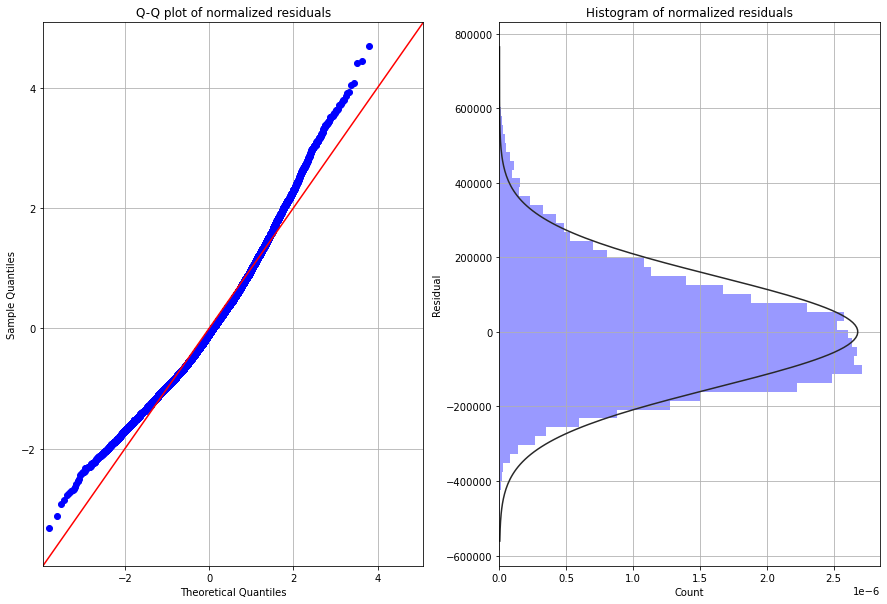

In [30]:
norm_dist_assumption(residuals)

In [31]:
# Will create a function to test for heteroskedasity
def Heteroskedasticity_test(model):
    plt.figure(figsize=(15,10))
    ax = sns.scatterplot(x = model.fittedvalues, y = model.resid)
    ax.grid()
    ax.axhline(y=0, color='r', linewidth=4) 
    ax.set_xlabel("Fitted Values");
    ax.set_ylabel("Residual");

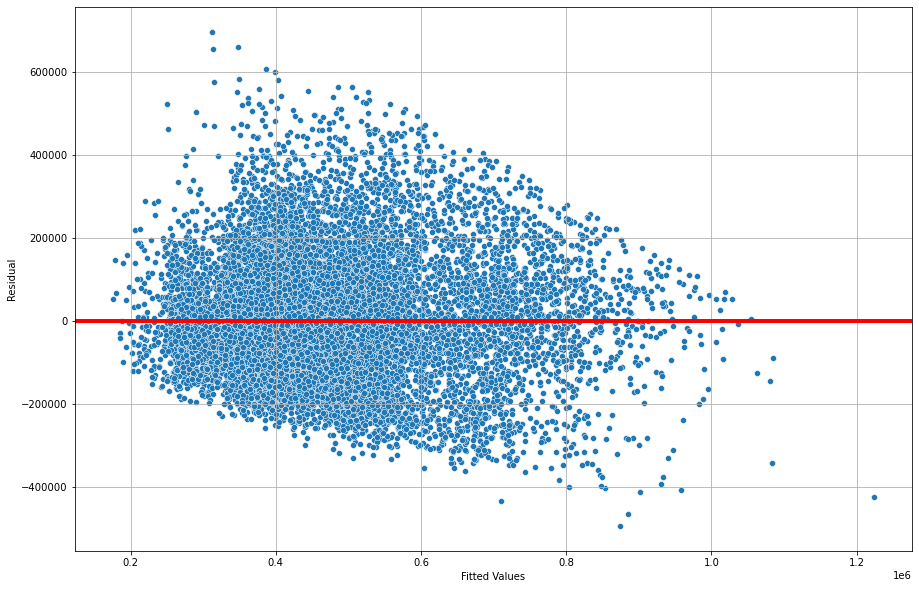

In [32]:
Heteroskedasticity_test(model1)

# Model 2

In the first model there were a few features that struggled with the lack of being normally distributed. To fix this issue we need to transform features by using techniques like performing log transformation and quantile transformation. In this next model I will experiment with log transformation. 

In [33]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 31 columns):
log_price                           18109 non-null float64
log_School_Elementary               18109 non-null float64
log_School_K_12                     18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
School_Junior_High_Middle_log       18109 non-null float64
dist_School_High_log                18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_School_Elementary_log            18109 non-null float64
police_station_dist_log             18109 non-null float64
sqft_living_log                     18109 non-null float64
sqft_lot_log                        18109 non-null float64
bathrooms                           18109 non-null float64
waterf

In [34]:
df_norm.head()

log_price  log_School_Elementary  log_School_K_12  ef_School_K_12_log  \
0   0.498255              -0.936137         0.238318            0.039586   
1  -1.981504              -1.852775        -1.046947           -1.353662   
2   0.760330               0.750625         0.469516            0.226359   
3   0.377205               0.302235        -0.215221           -1.288535   
4  -1.170555               0.263123        -1.718673           -0.799643   

   medical_dist_log  transport_dist_log  School_Junior_High_Middle_log  \
0         -0.367967           -1.142267                      -0.768040   
1          0.650214            0.677187                       0.972042   
2          0.234602            0.563919                       0.288633   
3          2.392165            0.967465                       0.146330   
4         -1.476924           -1.315559                       0.295690   

   dist_School_High_log  ef_School_Junior_High_Middle_log  \
0             -0.459830                         -0.569648   
1             -1.134748                          0.416952   
2              0.076291                          0.278952   
3             -0.744946                         -0.948499   
4              0.111034                          1.143145   

   ef_dist_School_High_log  ...   grade_9  grade_10  grade_11  grade_12  \
0                -0.346308  ... -0.354619 -0.196156 -0.081672 -0.012872   
1                -1.354717  ... -0.354619 -0.196156 -0.081672 -0.012872   
2                 0.114733  ... -0.354619 -0.196156 -0.081672 -0.012872   
3                -1.751188  ... -0.354619 -0.196156 -0.081672 -0.012872   
4                 1.039015  ... -0.354619 -0.196156 -0.081672 -0.012872   

   grade_rank_2  grade_rank_3  grade_rank_4  grade_rank_5  grade_rank_6  \
0     -0.385301      1.363916     -0.123944     -0.327061      -0.31301   
1      2.595229     -0.733142     -0.123944     -0.327061      -0.31301   
2     -0.385301      1.363916     -0.123944     -0.327061      -0.31301   
3     -0.385301     -0.733142     -0.123944     -0.327061      -0.31301   
4     -0.385301     -0.733142     -0.123944     -0.327061      -0.31301   

   grade_rank_7  
0     -0.376844  
1     -0.376844  
2     -0.376844  
3     -0.376844  
4      2.653471  

[5 rows x 31 columns]

In [35]:
target_value2 = ['log_price','bathrooms','sqft_lot_log','sqft_living_log','waterfront','grade_4','grade_5','grade_6','grade_7','grade_8','grade_9','grade_10','grade_11','grade_12',]

In [36]:
df_model2 = df_norm[target_value2]

In [37]:
df_model2

log_price  bathrooms  sqft_lot_log  sqft_living_log  waterfront  \
0       0.498255   0.283277     -0.085043         0.863210   -0.052617   
1      -1.981504  -1.481382      0.274759        -2.181299   -0.052617   
2       0.760330   1.342073     -0.498111         0.178763   -0.052617   
3       0.377205  -0.069655      0.037045        -0.210622   -0.052617   
4      -1.170555   0.283277     -0.152150        -0.158537   -0.052617   
...          ...        ...           ...              ...         ...   
18104   0.216185   0.636209     -2.005276        -0.839005   -0.052617   
18105  -0.411648   0.636209     -2.155397        -0.446868   -0.052617   
18106  -0.173025   0.636209     -0.330124         0.593791   -0.052617   
18107  -0.161160  -1.834314     -1.958037        -1.471071   -0.052617   
18108  -0.643292  -1.834314     -2.210983        -1.471071   -0.052617   

       grade_4   grade_5   grade_6   grade_7   grade_8   grade_9  grade_10  \
0     -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
1     -0.03718 -0.108834  3.001667 -0.885293 -0.642204 -0.354619 -0.196156   
2     -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
3     -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
4     -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
...        ...       ...       ...       ...       ...       ...       ...   
18104 -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
18105 -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
18106 -0.03718 -0.108834 -0.333130 -0.885293  1.557052 -0.354619 -0.196156   
18107 -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   
18108 -0.03718 -0.108834 -0.333130  1.129508 -0.642204 -0.354619 -0.196156   

       grade_11  grade_12  
0     -0.081672 -0.012872  
1     -0.081672 -0.012872  
2     -0.081672 -0.012872  
3     -0.081672 -0.012872  
4     -0.081672 -0.012872  
...         ...       ...  
18104 -0.081672 -0.012872  
18105 -0.081672 -0.012872  
18106 -0.081672 -0.012872  
18107 -0.081672 -0.012872  
18108 -0.081672 -0.012872  

[18109 rows x 14 columns]

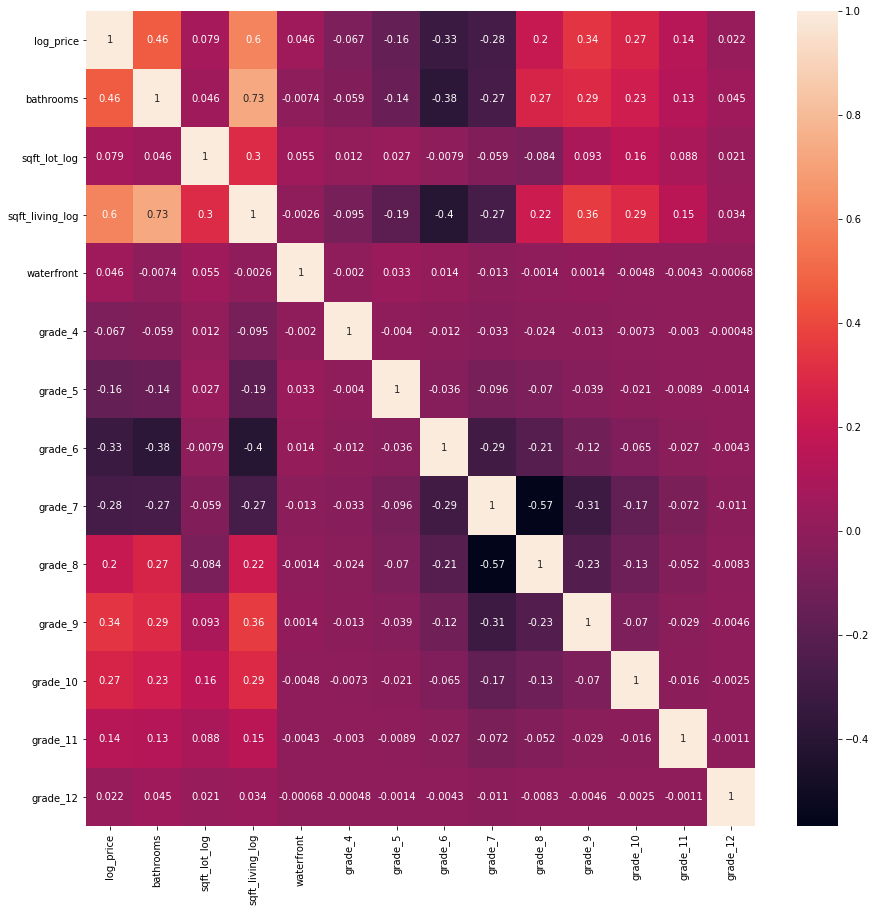

In [38]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model2.corr(),annot=True)

In [39]:
correlation(df_model2)

Empty DataFrame
Columns: [cc]
Index: []

In [40]:
train, test = train_test_split(df_model2)
print(len(train), len(test))

13581 4528


In [42]:
outcome = 'log_price'
x_cols = list(df_model2.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model2 = ols(formula=formula, data=train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     861.0
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:04:57   Log-Likelihood:                -15166.
No. Observations:               13581   AIC:                         3.036e+04
Df Residuals:                   13567   BIC:                         3.046e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0006      0.006     -0.099      0.921      -0.013       0.012
bathrooms          -0.0777      0.010     -7.834      0.000      -0.097      -0.058
sqft_lot_log       -0.0945      0.007    -13.463      0.000      -0.108      -0.081
sqft_living_log     0.4110      0.011     36.302      0.000       0.389       0.433
waterfront          0.0541      0.007      7.732      0.000       0.040       0.068
grade_4            -0.0319      0.028     -1.132      0.258      -0.087       0.023
grade_5            -0.1023      0.080     -1.282      0.200      -0.259       0.054
grade_6            -0.1928      0.222     -0.869      0.385      -0.628       0.242
grade_7            -0.1532      0.367     -0.417      0.677      -0.873       0.567
grade_8             0.0432      0.337      0.128      0.898      -0.617       0.703
grade_9             0.1684      0.233      0.721      0.471      -0.289       0.626
grade_10            0.1533      0.140      1.094      0.274      -0.121       0.428
grade_11            0.0901      0.060      1.490      0.136      -0.028       0.209
grade_12            0.0098      0.012      0.838      0.402      -0.013       0.033
==============================================================================
Omnibus:                       54.261   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.279
Skew:                          -0.077   Prob(JB):                     1.47e-10
Kurtosis:                       2.763   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model 2 Interpetation:

Overall: 

Omnibus:

Durbin-Watson:

In [43]:
vif(train)

[('bathrooms', 2.4542317474143975),
 ('sqft_lot_log', 1.229235005981897),
 ('sqft_living_log', 3.2226220447326566),
 ('waterfront', 1.0043157877708926),
 ('grade_4', 18.97606007124498),
 ('grade_5', 169.9106466459039),
 ('grade_6', 1232.8989576743336),
 ('grade_7', 3349.626059766414),
 ('grade_8', 2805.8450951974996),
 ('grade_9', 1362.4471419955553),
 ('grade_10', 487.88233390855777),
 ('grade_11', 84.79951437735505),
 ('grade_12', 3.012710879854409)]

In [44]:
residuals = model2.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


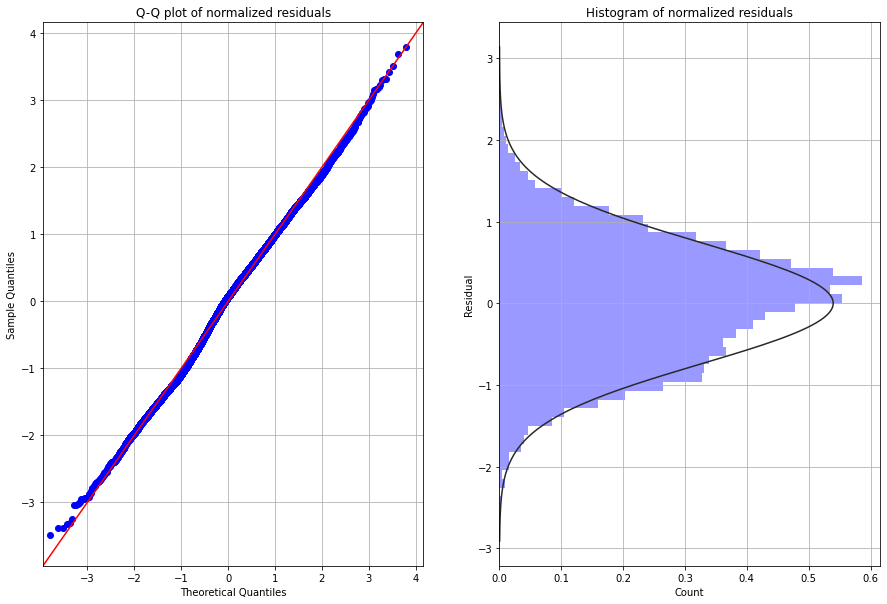

In [45]:
norm_dist_assumption(residuals)

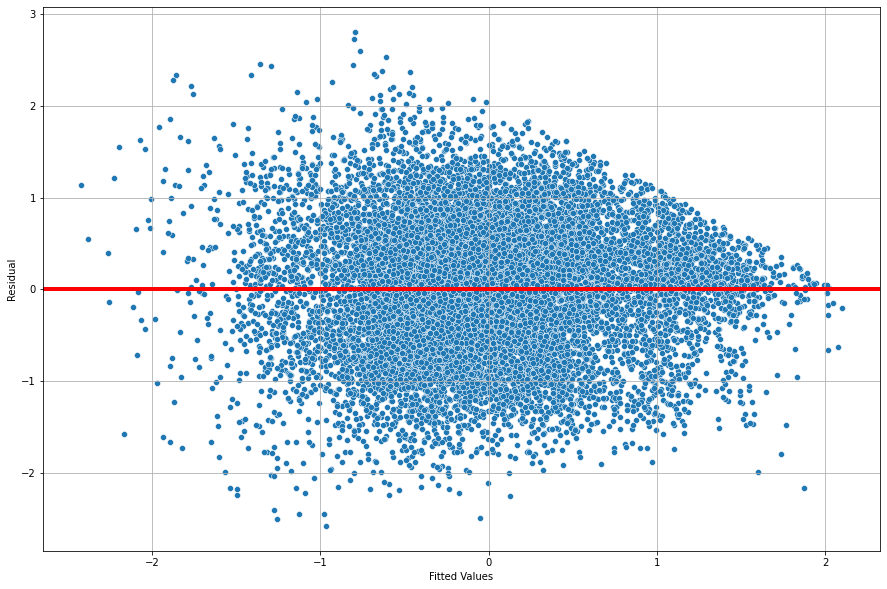

In [46]:
Heteroskedasticity_test(model2)

In [49]:
#Backward Elimination
y = df_model2['log_price']
cols = x_cols
X = df_model2[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['bathrooms', 'sqft_lot_log', 'sqft_living_log', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_9', 'grade_10', 'grade_11']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [50]:
predictors_be_2 = '+'.join(selected_features_BE_norm)
formula_be_2 = outcome + '~' + predictors_be_2
model_be_2 = ols(formula=formula_be_2, data=train).fit()
model_be_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1017.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:32:08   Log-Likelihood:                -15166.
No. Observations:               13581   AIC:                         3.036e+04
Df Residuals:                   13569   BIC:                         3.045e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0006      0.006     -0.101      0.920      -0.013       0.012
bathrooms          -0.0771      0.010     -7.783      0.000      -0.097      -0.058
sqft_lot_log       -0.0944      0.007    -13.447      0.000      -0.108      -0.081
sqft_living_log     0.4111      0.011     36.343      0.000       0.389       0.433
waterfront          0.0541      0.007      7.730      0.000       0.040       0.068
grade_4            -0.0354      0.007     -5.386      0.000      -0.048      -0.023
grade_5            -0.1124      0.007    -17.001      0.000      -0.125      -0.099
grade_6            -0.2210      0.008    -26.424      0.000      -0.237      -0.205
grade_7            -0.2002      0.008    -24.270      0.000      -0.216      -0.184
grade_9             0.1382      0.007     19.018      0.000       0.124       0.152
grade_10            0.1351      0.007     19.547      0.000       0.122       0.149
grade_11            0.0823      0.007     12.248      0.000       0.069       0.095
==============================================================================
Omnibus:                       54.566   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.485
Skew:                          -0.077   Prob(JB):                     1.33e-10
Kurtosis:                       2.762   Cond. No.                         3.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
vif(train[selected_features_BE_norm])

[('bathrooms', 2.448749562192335),
 ('sqft_lot_log', 1.2283121237228751),
 ('sqft_living_log', 3.2176193192317473),
 ('waterfront', 1.0043109204341845),
 ('grade_4', 1.0302945551367966),
 ('grade_5', 1.1663246203673736),
 ('grade_6', 1.7511178964983203),
 ('grade_7', 1.689617891343113),
 ('grade_9', 1.3217025563186726),
 ('grade_10', 1.188760500618192),
 ('grade_11', 1.0468895125308952)]

# Model 2 after Backward Elimination interperation:



# Model 3

In [52]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 31 columns):
log_price                           18109 non-null float64
log_School_Elementary               18109 non-null float64
log_School_K_12                     18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
School_Junior_High_Middle_log       18109 non-null float64
dist_School_High_log                18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_School_Elementary_log            18109 non-null float64
police_station_dist_log             18109 non-null float64
sqft_living_log                     18109 non-null float64
sqft_lot_log                        18109 non-null float64
bathrooms                           18109 non-null float64
waterf

In [54]:
df_model3 = df_norm.drop(['police_station_dist_log','transport_dist_log','medical_dist_log','log_School_Elementary','log_School_K_12','dist_School_High_log','School_Junior_High_Middle_log','ef_School_K_12_log','ef_School_Junior_High_Middle_log','ef_dist_School_High_log','ef_School_Elementary_log'], axis=1)

In [55]:
df_model3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 20 columns):
log_price          18109 non-null float64
sqft_living_log    18109 non-null float64
sqft_lot_log       18109 non-null float64
bathrooms          18109 non-null float64
waterfront         18109 non-null float64
grade_4            18109 non-null float64
grade_5            18109 non-null float64
grade_6            18109 non-null float64
grade_7            18109 non-null float64
grade_8            18109 non-null float64
grade_9            18109 non-null float64
grade_10           18109 non-null float64
grade_11           18109 non-null float64
grade_12           18109 non-null float64
grade_rank_2       18109 non-null float64
grade_rank_3       18109 non-null float64
grade_rank_4       18109 non-null float64
grade_rank_5       18109 non-null float64
grade_rank_6       18109 non-null float64
grade_rank_7       18109 non-null float64
dtypes: float64(20)
memory usage: 2.8 MB


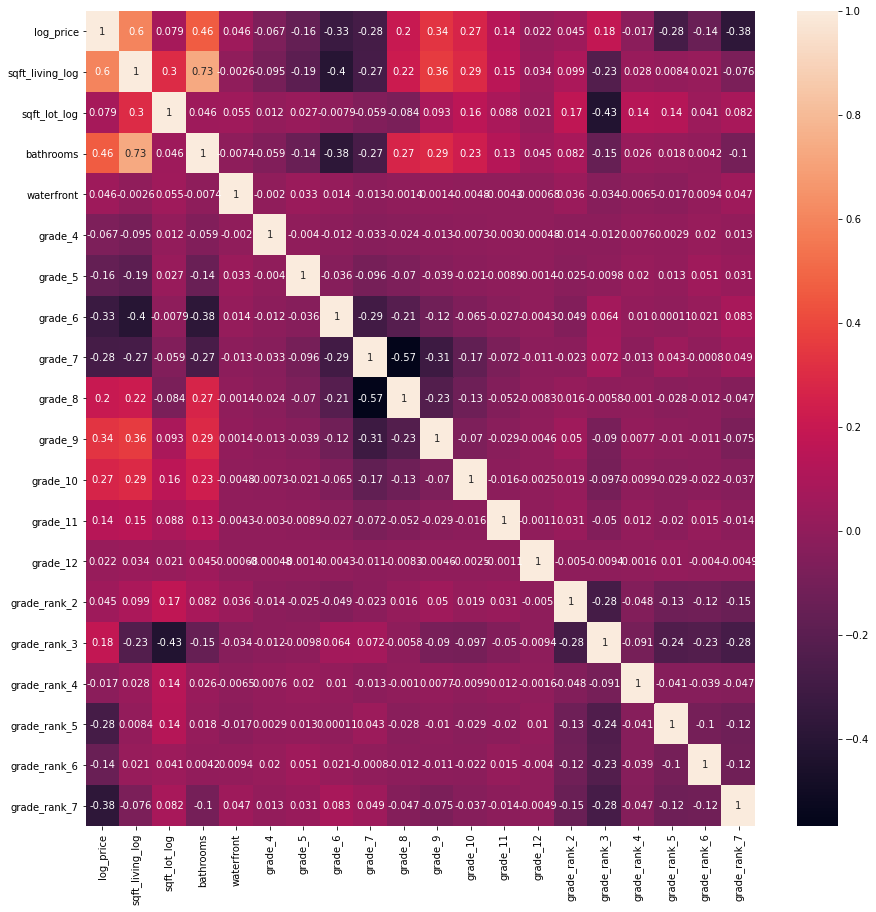

In [56]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model3.corr(),annot=True)

In [57]:
correlation(df_model3)

Empty DataFrame
Columns: [cc]
Index: []

In [58]:
train, test = train_test_split(df_model3)
print(len(train), len(test))

13581 4528


In [59]:
outcome = 'log_price'
x_cols = list(df_model3.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model3 = ols(formula=formula, data=train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1766.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:08:20   Log-Likelihood:                -10781.
No. Observations:               13581   AIC:                         2.160e+04
Df Residuals:                   13561   BIC:                         2.175e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0004      0.005     -0.088      0.930      -0.009       0.009
sqft_living_log     0.4009      0.008     48.595      0.000       0.385       0.417
sqft_lot_log        0.0655      0.006     11.639      0.000       0.054       0.076
bathrooms          -0.0307      0.007     -4.258      0.000      -0.045      -0.017
waterfront          0.0703      0.005     15.539      0.000       0.061       0.079
grade_4            -0.0545      0.020     -2.664      0.008      -0.095      -0.014
grade_5            -0.1582      0.058     -2.736      0.006      -0.272      -0.045
grade_6            -0.4095      0.161     -2.547      0.011      -0.725      -0.094
grade_7            -0.5356      0.266     -2.012      0.044      -1.057      -0.014
grade_8            -0.3506      0.244     -1.437      0.151      -0.829       0.127
grade_9            -0.1393      0.169     -0.824      0.410      -0.471       0.192
grade_10           -0.0552      0.101     -0.544      0.587      -0.254       0.144
grade_11           -0.0019      0.044     -0.044      0.965      -0.088       0.084
grade_12           -0.0034      0.008     -0.432      0.666      -0.019       0.012
grade_rank_2       -0.1646      0.006    -29.478      0.000      -0.176      -0.154
grade_rank_3        0.0275      0.007      4.072      0.000       0.014       0.041
grade_rank_4       -0.0867      0.005    -18.102      0.000      -0.096      -0.077
grade_rank_5       -0.3772      0.005    -69.318      0.000      -0.388      -0.367
grade_rank_6       -0.2490      0.005    -46.197      0.000      -0.260      -0.238
grade_rank_7       -0.4177      0.006    -73.009      0.000      -0.429      -0.406
==============================================================================
Omnibus:                      315.656   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.802
Skew:                          -0.055   Prob(JB):                    8.21e-157
Kurtosis:                       4.122   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
vif(train)

[('sqft_living_log', 3.199351026706086),
 ('sqft_lot_log', 1.503157727105573),
 ('bathrooms', 2.4459399683954777),
 ('waterfront', 1.0075426461321388),
 ('grade_4', 18.98677971425699),
 ('grade_5', 162.2038227724821),
 ('grade_6', 1201.6792054179275),
 ('grade_7', 3354.1002188156986),
 ('grade_8', 2826.2890293528903),
 ('grade_9', 1347.93113286576),
 ('grade_10', 488.3387378485428),
 ('grade_11', 89.84164419995031),
 ('grade_12', 4.018202307791379),
 ('grade_rank_2', 1.4878192433779904),
 ('grade_rank_3', 2.1601339954733954),
 ('grade_rank_4', 1.088749172646194),
 ('grade_rank_5', 1.4163958117508864),
 ('grade_rank_6', 1.3758412495671557),
 ('grade_rank_7', 1.5328558310253022)]

In [61]:
residuals = model3.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


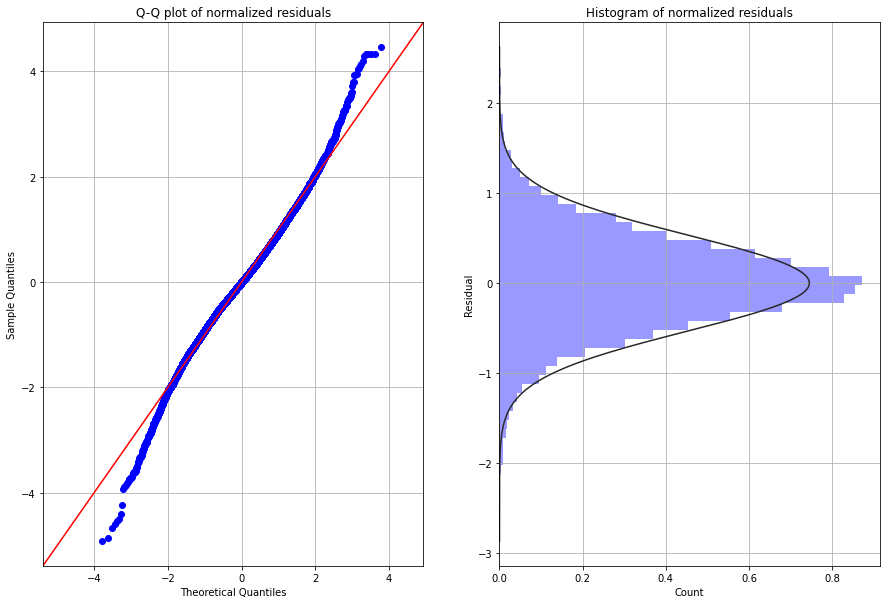

In [62]:
norm_dist_assumption(residuals)

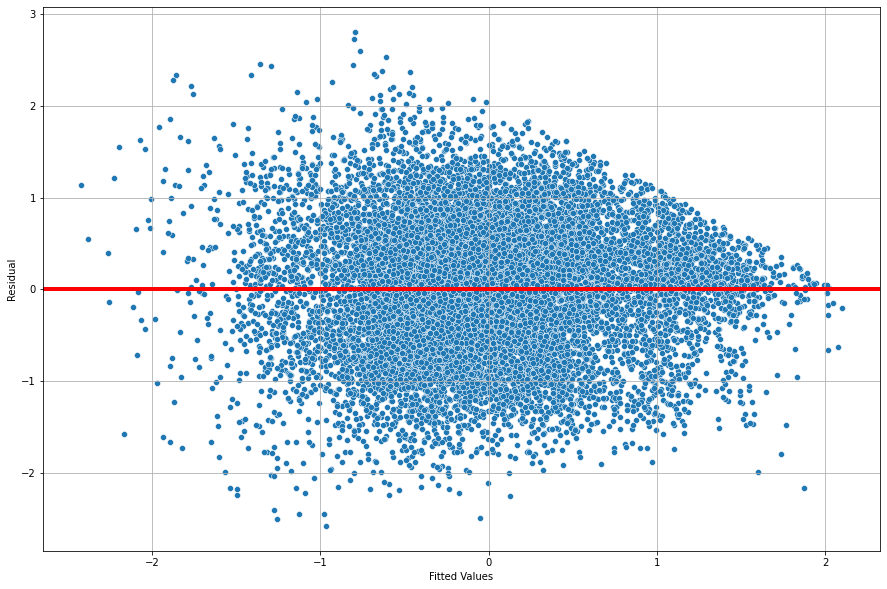

In [63]:
Heteroskedasticity_test(model3)

# Model 3 Interpetation:

Overall: 

Omnibus:

Durbin-Watson:

In [64]:
#Backward Elimination
y = df_model3['log_price']
cols = x_cols
X = df_model3[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [65]:
predictors_be_3 = '+'.join(selected_features_BE_norm)
formula_be_3 = outcome + '~' + predictors_be_3
model_be_3 = ols(formula=formula_be_3, data=train).fit()
model_be_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1973.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:15:59   Log-Likelihood:                -10782.
No. Observations:               13581   AIC:                         2.160e+04
Df Residuals:                   13563   BIC:                         2.173e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0004      0.005     -0.091      0.928      -0.009       0.009
sqft_living_log     0.4009      0.008     48.657      0.000       0.385       0.417
sqft_lot_log        0.0654      0.006     11.632      0.000       0.054       0.076
bathrooms          -0.0308      0.007     -4.286      0.000      -0.045      -0.017
waterfront          0.0703      0.005     15.540      0.000       0.061       0.079
grade_4            -0.0533      0.005    -10.160      0.000      -0.064      -0.043
grade_5            -0.1549      0.008    -19.504      0.000      -0.170      -0.139
grade_6            -0.4003      0.018    -21.774      0.000      -0.436      -0.364
grade_7            -0.5201      0.029    -18.055      0.000      -0.577      -0.464
grade_8            -0.3364      0.026    -12.920      0.000      -0.387      -0.285
grade_9            -0.1295      0.018     -7.130      0.000      -0.165      -0.094
grade_10           -0.0493      0.011     -4.306      0.000      -0.072      -0.027
grade_rank_2       -0.1645      0.006    -29.471      0.000      -0.175      -0.154
grade_rank_3        0.0275      0.007      4.075      0.000       0.014       0.041
grade_rank_4       -0.0867      0.005    -18.096      0.000      -0.096      -0.077
grade_rank_5       -0.3772      0.005    -69.347      0.000      -0.388      -0.367
grade_rank_6       -0.2489      0.005    -46.194      0.000      -0.259      -0.238
grade_rank_7       -0.4176      0.006    -73.009      0.000      -0.429      -0.406
==============================================================================
Omnibus:                      315.738   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.929
Skew:                          -0.055   Prob(JB):                    7.70e-157
Kurtosis:                       4.122   Cond. No.                         16.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
vif(train[selected_features_BE_norm])

[('sqft_living_log', 3.1917625198595063),
 ('sqft_lot_log', 1.5028553148089552),
 ('bathrooms', 2.4433162626539944),
 ('waterfront', 1.0075414841258294),
 ('grade_4', 1.2513170015677153),
 ('grade_5', 3.0594126899553453),
 ('grade_6', 15.707745265883176),
 ('grade_7', 39.30634227783289),
 ('grade_8', 32.21054252876486),
 ('grade_9', 15.548087348828323),
 ('grade_10', 6.205974939557319),
 ('grade_rank_2', 1.487497031554823),
 ('grade_rank_3', 2.160112030145644),
 ('grade_rank_4', 1.0886353888633247),
 ('grade_rank_5', 1.4153903059077153),
 ('grade_rank_6', 1.3756436205000226),
 ('grade_rank_7', 1.532749744290748)]

# Model 4

Will add the distance to schools

In [67]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 31 columns):
log_price                           18109 non-null float64
log_School_Elementary               18109 non-null float64
log_School_K_12                     18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
School_Junior_High_Middle_log       18109 non-null float64
dist_School_High_log                18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_School_Elementary_log            18109 non-null float64
police_station_dist_log             18109 non-null float64
sqft_living_log                     18109 non-null float64
sqft_lot_log                        18109 non-null float64
bathrooms                           18109 non-null float64
waterf

In [68]:
df_model4 = df_norm.drop(['police_station_dist_log','transport_dist_log','medical_dist_log','ef_School_K_12_log','ef_School_Junior_High_Middle_log','ef_dist_School_High_log','ef_School_Elementary_log'], axis=1)

In [69]:
df_model4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 24 columns):
log_price                        18109 non-null float64
log_School_Elementary            18109 non-null float64
log_School_K_12                  18109 non-null float64
School_Junior_High_Middle_log    18109 non-null float64
dist_School_High_log             18109 non-null float64
sqft_living_log                  18109 non-null float64
sqft_lot_log                     18109 non-null float64
bathrooms                        18109 non-null float64
waterfront                       18109 non-null float64
grade_4                          18109 non-null float64
grade_5                          18109 non-null float64
grade_6                          18109 non-null float64
grade_7                          18109 non-null float64
grade_8                          18109 non-null float64
grade_9                          18109 non-null float64
grade_10                         18109 non-null flo

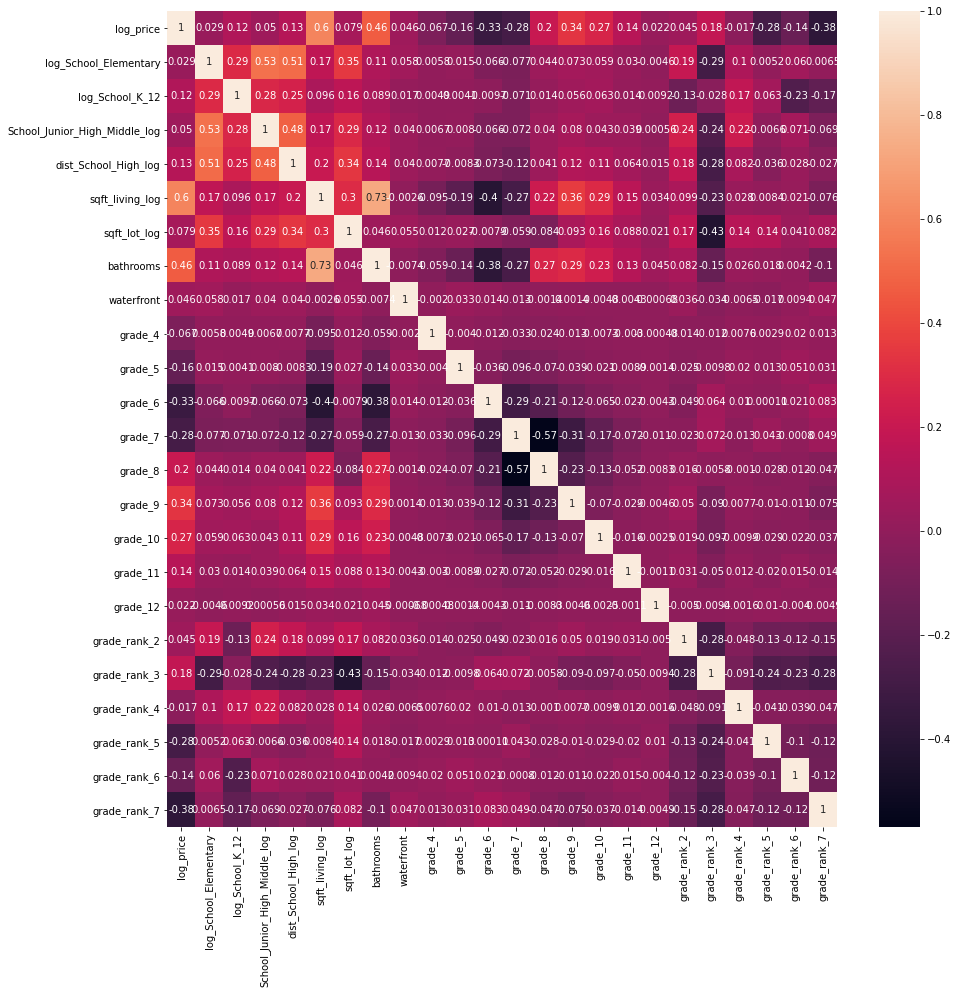

In [70]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model4.corr(),annot=True)

In [71]:
correlation(df_model4)

Empty DataFrame
Columns: [cc]
Index: []

In [72]:
train, test = train_test_split(df_model4)
print(len(train), len(test))

13581 4528


In [73]:
outcome = 'log_price'
x_cols = list(df_model4.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model4 = ols(formula=formula, data=train).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1618.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:35:43   Log-Likelihood:                -10609.
No. Observations:               13581   AIC:                         2.126e+04
Df Residuals:                   13558   BIC:                         2.144e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0009      0.005      0.206      0.837      -0.008       0.010
log_School_Elementary            -0.0182      0.006     -3.075      0.002      -0.030      -0.007
log_School_K_12                  -0.0921      0.006    -16.390      0.000      -0.103      -0.081
School_Junior_High_Middle_log    -0.0056      0.006     -0.954      0.340      -0.017       0.006
dist_School_High_log              0.0300      0.006      5.256      0.000       0.019       0.041
sqft_living_log                   0.4031      0.008     49.666      0.000       0.387       0.419
sqft_lot_log                      0.0836      0.006     14.389      0.000       0.072       0.095
bathrooms                        -0.0231      0.007     -3.259      0.001      -0.037      -0.009
waterfront                        0.0752      0.004     16.800      0.000       0.066       0.084
grade_4                          -0.0170      0.005     -3.743      0.000      -0.026      -0.008
grade_5                          -0.0613      0.005    -13.153      0.000      -0.070      -0.052
grade_6                          -0.1335      0.005    -27.917      0.000      -0.143      -0.124
grade_7                          -0.0942      0.003    -29.251      0.000      -0.100      -0.088
grade_8                           0.0577      0.003     16.696      0.000       0.051       0.064
grade_9                           0.1360      0.004     30.670      0.000       0.127       0.145
grade_10                          0.1028      0.005     21.559      0.000       0.093       0.112
grade_11                          0.0670      0.005     14.489      0.000       0.058       0.076
grade_12                          0.0075      0.007      1.102      0.271      -0.006       0.021
grade_rank_2                     -0.2004      0.006    -32.848      0.000      -0.212      -0.188
grade_rank_3                     -0.0016      0.007     -0.238      0.812      -0.015       0.012
grade_rank_4                     -0.0797      0.005    -16.412      0.000      -0.089      -0.070
grade_rank_5                     -0.3914      0.005    -71.189      0.000      -0.402      -0.381
grade_rank_6                     -0.2898      0.006    -49.187      0.000      -0.301      -0.278
grade_rank_7                     -0.4542      0.006    -75.851      0.000      -0.466      -0.442
==============================================================================
Omnibus:                      303.270   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              692.943
Skew:                           0.001   Prob(JB):                    3.38e-151
Kurtosis:                       4.107   Cond. No.                     5.54e+15
==========================================

In [74]:
vif(train)

[('log_School_Elementary', 1.7109164661114171),
 ('log_School_K_12', 1.5423284153605294),
 ('School_Junior_High_Middle_log', 1.7133840731034757),
 ('dist_School_High_log', 1.5891997115294934),
 ('sqft_living_log', 3.2260566508821986),
 ('sqft_lot_log', 1.6401873701804652),
 ('bathrooms', 2.4471244588846166),
 ('waterfront', 1.0107668673087933),
 ('grade_4', 458298.9927318977),
 ('grade_5', 3842818.2470322046),
 ('grade_6', 29638150.97507604),
 ('grade_7', 80828750.46676958),
 ('grade_8', 67812374.47603351),
 ('grade_9', 32512275.06959679),
 ('grade_10', 11431511.116746956),
 ('grade_11', 2159523.787146772),
 ('grade_12', 24160.060248330774),
 ('grade_rank_2', 1.7990476349572475),
 ('grade_rank_3', 2.3133295744761986),
 ('grade_rank_4', 1.140822881634942),
 ('grade_rank_5', 1.463238333834893),
 ('grade_rank_6', 1.6795530762548314),
 ('grade_rank_7', 1.7750660713769988)]

In [75]:
residuals = model4.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


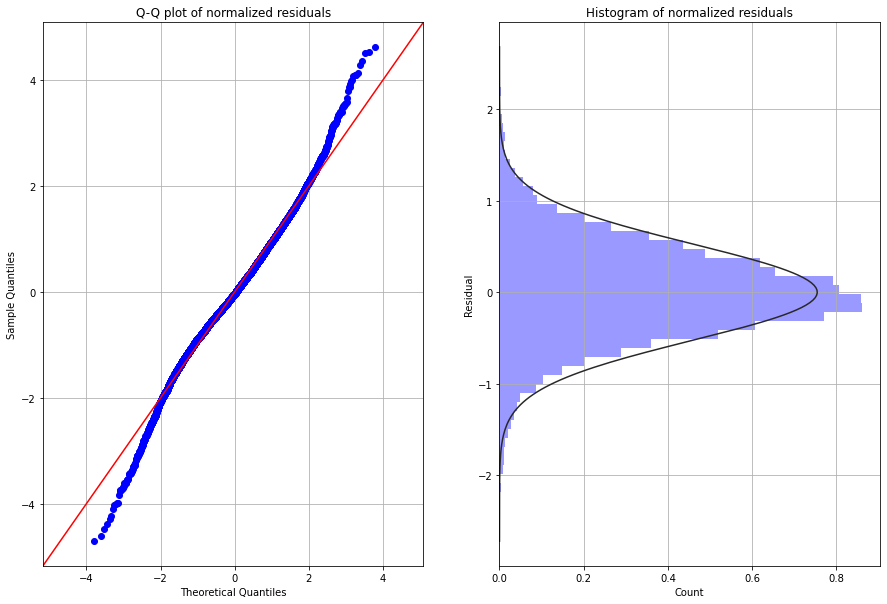

In [76]:
norm_dist_assumption(residuals)

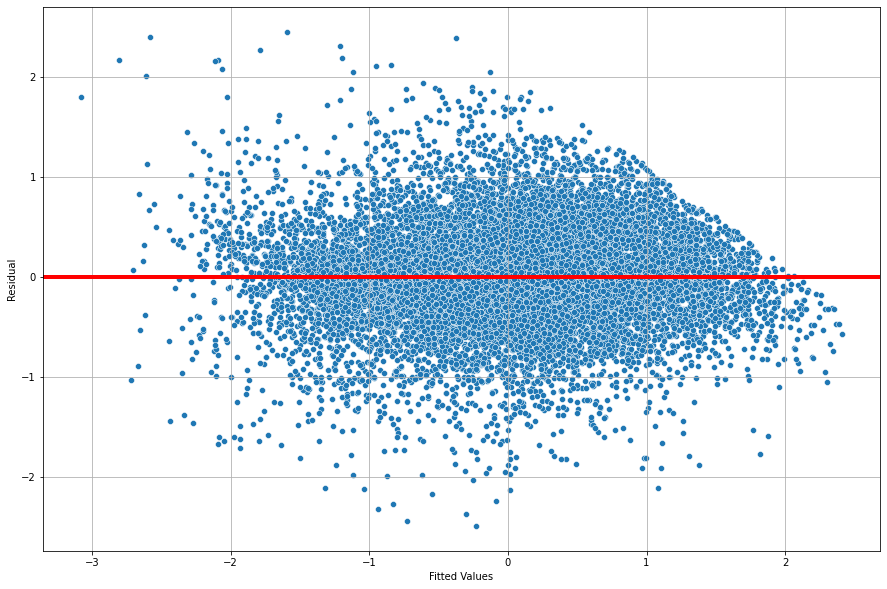

In [77]:
Heteroskedasticity_test(model4)

In [78]:
#Backward Elimination
y = df_model4['log_price']
cols = x_cols
X = df_model4[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['log_School_Elementary', 'log_School_K_12', 'dist_School_High_log', 'sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


In [79]:
predictors_be_4 = '+'.join(selected_features_BE_norm)
formula_be_4 = outcome + '~' + predictors_be_4
model_be_4 = ols(formula=formula_be_4, data=train).fit()
model_be_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1874.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:41:17   Log-Likelihood:                -10610.
No. Observations:               13581   AIC:                         2.126e+04
Df Residuals:                   13561   BIC:                         2.141e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0010      0.005      0.220      0.826      -0.008       0.010
log_School_Elementary    -0.0199      0.006     -3.523      0.000      -0.031      -0.009
log_School_K_12          -0.0928      0.005    -17.107      0.000      -0.103      -0.082
dist_School_High_log      0.0288      0.005      5.239      0.000       0.018       0.040
sqft_living_log           0.4029      0.008     49.668      0.000       0.387       0.419
sqft_lot_log              0.0838      0.006     14.703      0.000       0.073       0.095
bathrooms                -0.0231      0.007     -3.254      0.001      -0.037      -0.009
waterfront                0.0751      0.004     16.797      0.000       0.066       0.084
grade_4                  -0.0476      0.005     -9.386      0.000      -0.058      -0.038
grade_5                  -0.1500      0.008    -18.884      0.000      -0.166      -0.134
grade_6                  -0.3806      0.018    -20.730      0.000      -0.417      -0.345
grade_7                  -0.5030      0.029    -17.463      0.000      -0.559      -0.447
grade_8                  -0.3168      0.026    -12.178      0.000      -0.368      -0.266
grade_9                  -0.1234      0.018     -6.807      0.000      -0.159      -0.088
grade_10                 -0.0525      0.011     -4.597      0.000      -0.075      -0.030
grade_rank_2             -0.2007      0.005    -38.437      0.000      -0.211      -0.191
grade_rank_4             -0.0803      0.005    -17.087      0.000      -0.090      -0.071
grade_rank_5             -0.3910      0.005    -80.466      0.000      -0.401      -0.381
grade_rank_6             -0.2897      0.005    -56.861      0.000      -0.300      -0.280
grade_rank_7             -0.4535      0.005    -90.410      0.000      -0.463      -0.444
==============================================================================
Omnibus:                      305.509   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.526
Skew:                          -0.000   Prob(JB):                    7.63e-153
Kurtosis:                       4.113   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
vif(train[selected_features_BE_norm])

[('log_School_Elementary', 1.5541546438717795),
 ('log_School_K_12', 1.4358112892945605),
 ('dist_School_High_log', 1.4730115175457483),
 ('sqft_living_log', 3.22342097130625),
 ('sqft_lot_log', 1.5782902365507656),
 ('bathrooms', 2.4425814808531494),
 ('waterfront', 1.0102492371715301),
 ('grade_4', 1.2675133764126014),
 ('grade_5', 3.0999469580995003),
 ('grade_6', 16.438598048208323),
 ('grade_7', 40.292367717908085),
 ('grade_8', 32.85195628141113),
 ('grade_9', 15.934024257646081),
 ('grade_10', 6.193537943713013),
 ('grade_rank_2', 1.318612858526395),
 ('grade_rank_4', 1.070941072953245),
 ('grade_rank_5', 1.1428309941898573),
 ('grade_rank_6', 1.2567747938348224),
 ('grade_rank_7', 1.2457960507622825)]

# Model 5

In [81]:
df_model5 = df_norm.drop(['police_station_dist_log','transport_dist_log','medical_dist_log','log_School_Elementary','log_School_K_12','dist_School_High_log','School_Junior_High_Middle_log'], axis=1)

In [82]:
df_model5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 24 columns):
log_price                           18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_School_Elementary_log            18109 non-null float64
sqft_living_log                     18109 non-null float64
sqft_lot_log                        18109 non-null float64
bathrooms                           18109 non-null float64
waterfront                          18109 non-null float64
grade_4                             18109 non-null float64
grade_5                             18109 non-null float64
grade_6                             18109 non-null float64
grade_7                             18109 non-null float64
grade_8                             18109 non-null float64
grade_9                             18109 non-null float64
grade_

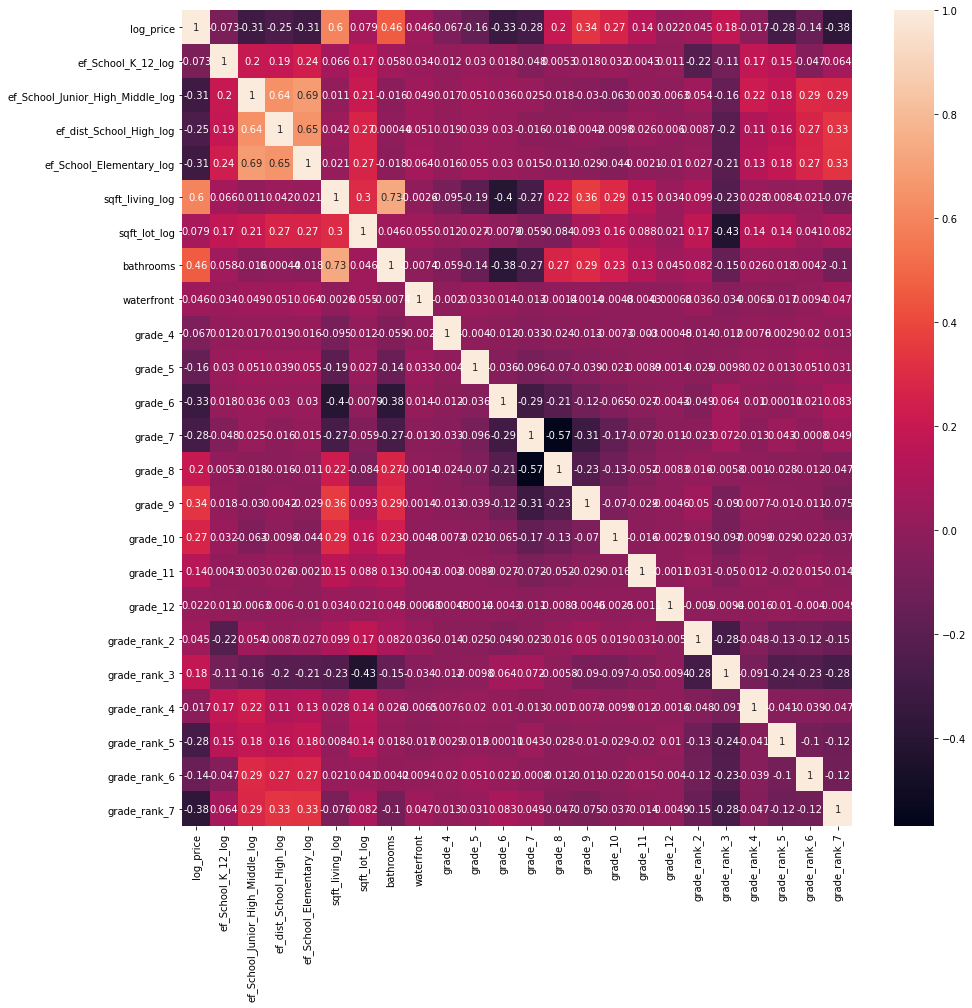

In [83]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model5.corr(),annot=True)

In [84]:
correlation(df_model5)

Empty DataFrame
Columns: [cc]
Index: []

In [85]:
train, test = train_test_split(df_model5)
print(len(train), len(test))

13581 4528


In [86]:
outcome = 'log_price'
x_cols = list(df_model5.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model5 = ols(formula=formula, data=train).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1540.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:51:39   Log-Likelihood:                -10526.
No. Observations:               13581   AIC:                         2.110e+04
Df Residuals:                   13557   BIC:                         2.128e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0031      0.005     -0.682      0.495      -0.012       0.006
ef_School_K_12_log                  -0.0752      0.005    -14.646      0.000      -0.085      -0.065
ef_School_Junior_High_Middle_log    -0.0125      0.007     -1.716      0.086      -0.027       0.002
ef_dist_School_High_log              0.0256      0.007      3.852      0.000       0.013       0.039
ef_School_Elementary_log            -0.0207      0.007     -2.931      0.003      -0.035      -0.007
sqft_living_log                      0.3928      0.008     48.629      0.000       0.377       0.409
sqft_lot_log                         0.0818      0.006     14.195      0.000       0.070       0.093
bathrooms                           -0.0204      0.007     -2.850      0.004      -0.034      -0.006
waterfront                           0.0641      0.005     13.662      0.000       0.055       0.073
grade_4                             -0.0594      0.020     -2.955      0.003      -0.099      -0.020
grade_5                             -0.1616      0.057     -2.848      0.004      -0.273      -0.050
grade_6                             -0.4169      0.158     -2.641      0.008      -0.726      -0.108
grade_7                             -0.5559      0.261     -2.128      0.033      -1.068      -0.044
grade_8                             -0.3666      0.239     -1.531      0.126      -0.836       0.103
grade_9                             -0.1498      0.166     -0.902      0.367      -0.475       0.176
grade_10                            -0.0651      0.100     -0.654      0.513      -0.260       0.130
grade_11                            -0.0045      0.043     -0.104      0.917      -0.089       0.080
grade_12                            -0.0042      0.008     -0.542      0.588      -0.020       0.011
grade_rank_2                        -0.1796      0.007    -27.624      0.000      -0.192      -0.167
grade_rank_3                         0.0186      0.008      2.457      0.014       0.004       0.034
grade_rank_4                        -0.0709      0.005    -13.773      0.000      -0.081      -0.061
grade_rank_5                        -0.3690      0.006    -57.918      0.000      -0.382      -0.357
grade_rank_6                        -0.2534      0.007    -36.554      0.000      -0.267      -0.240
grade_rank_7                        -0.4134      0.007    -55.982      0.000      -0.428      -0.399
==============================================================================
Omnibus:                      322.839   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              760.443
Skew:                          -0.003   Prob(JB):                    7.45e-166
Kurtosis:                       4.159   

In [87]:
vif(train)

[('ef_School_K_12_log', 1.2926674864582521),
 ('ef_School_Junior_High_Middle_log', 2.6188527194166697),
 ('ef_dist_School_High_log', 2.160436379606279),
 ('ef_School_Elementary_log', 2.471629004703715),
 ('sqft_living_log', 3.1990296301288703),
 ('sqft_lot_log', 1.628977459812194),
 ('bathrooms', 2.491170089734752),
 ('waterfront', 1.0112339973205602),
 ('grade_4', 17.993377110113368),
 ('grade_5', 164.22501570127088),
 ('grade_6', 1222.1239358926516),
 ('grade_7', 3348.746630674783),
 ('grade_8', 2828.715366483451),
 ('grade_9', 1380.431601959112),
 ('grade_10', 476.4546816785213),
 ('grade_11', 87.89032756351018),
 ('grade_12', 4.01891806379885),
 ('grade_rank_2', 2.088836255749693),
 ('grade_rank_3', 2.821115779219811),
 ('grade_rank_4', 1.310781294210397),
 ('grade_rank_5', 1.9859221270939806),
 ('grade_rank_6', 2.405638838898099),
 ('grade_rank_7', 2.7257911151277496)]

In [88]:
residuals = model5.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


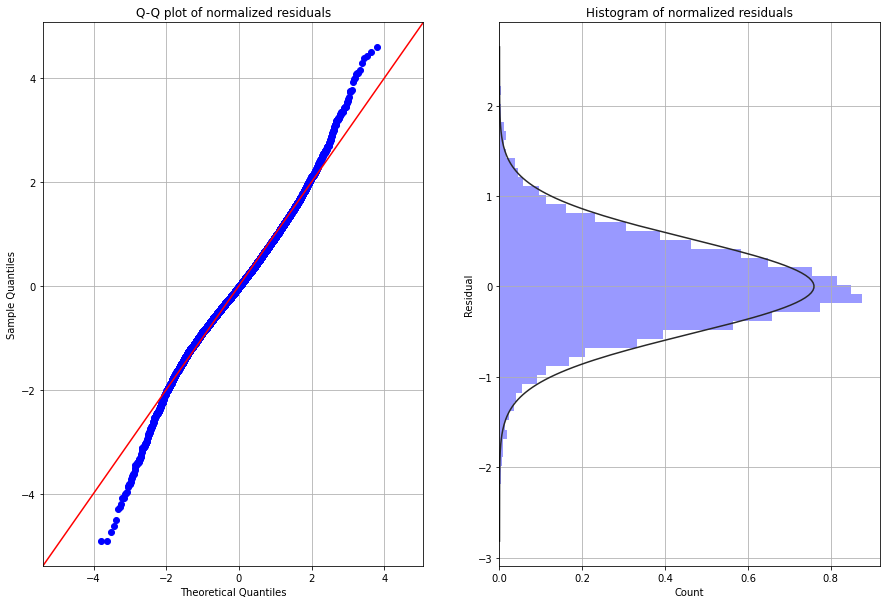

In [89]:
norm_dist_assumption(residuals)

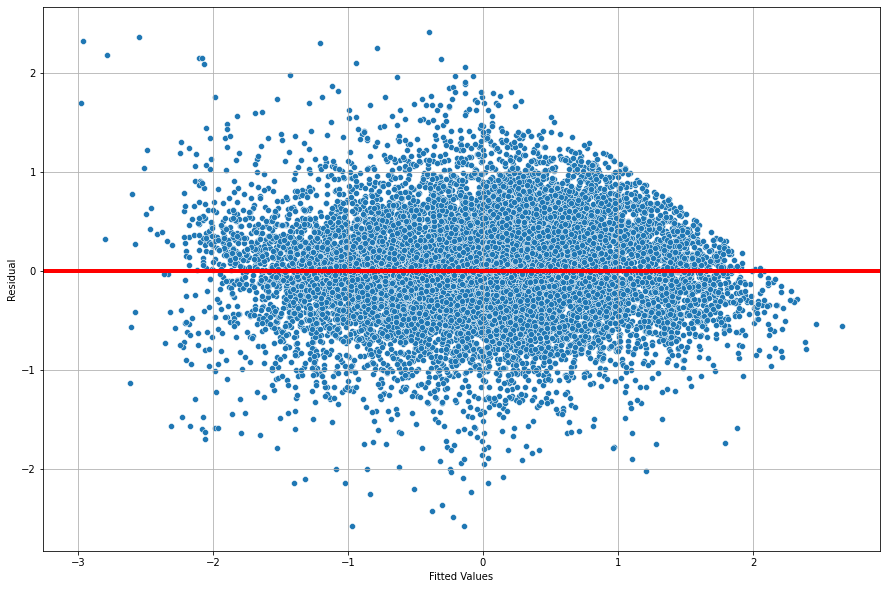

In [90]:
Heteroskedasticity_test(model5)

In [91]:
#Backward Elimination
y = df_model5['log_price']
cols = x_cols
X = df_model5[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12_log', 'ef_dist_School_High_log', 'ef_School_Elementary_log', 'sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [92]:
predictors_be_5 = '+'.join(selected_features_BE_norm)
formula_be_5 = outcome + '~' + predictors_be_5
model_be_5 = ols(formula=formula_be_5, data=train).fit()
model_be_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1771.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:57:50   Log-Likelihood:                -10528.
No. Observations:               13581   AIC:                         2.110e+04
Df Residuals:                   13560   BIC:                         2.126e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0031      0.005     -0.684      0.494      -0.012       0.006
ef_School_K_12_log          -0.0763      0.005    -14.970      0.000      -0.086      -0.066
ef_dist_School_High_log      0.0227      0.006      3.528      0.000       0.010       0.035
ef_School_Elementary_log    -0.0245      0.007     -3.654      0.000      -0.038      -0.011
sqft_living_log              0.3924      0.008     48.653      0.000       0.377       0.408
sqft_lot_log                 0.0815      0.006     14.154      0.000       0.070       0.093
bathrooms                   -0.0206      0.007     -2.887      0.004      -0.035      -0.007
waterfront                   0.0641      0.005     13.662      0.000       0.055       0.073
grade_4                     -0.0571      0.005    -10.818      0.000      -0.067      -0.047
grade_5                     -0.1549      0.008    -19.745      0.000      -0.170      -0.140
grade_6                     -0.3980      0.018    -21.815      0.000      -0.434      -0.362
grade_7                     -0.5247      0.029    -18.334      0.000      -0.581      -0.469
grade_8                     -0.3380      0.026    -13.073      0.000      -0.389      -0.287
grade_9                     -0.1299      0.018     -7.214      0.000      -0.165      -0.095
grade_10                    -0.0530      0.011     -4.663      0.000      -0.075      -0.031
grade_rank_2                -0.1828      0.006    -29.430      0.000      -0.195      -0.171
grade_rank_3                 0.0150      0.007      2.059      0.039       0.001       0.029
grade_rank_4                -0.0735      0.005    -14.993      0.000      -0.083      -0.064
grade_rank_5                -0.3722      0.006    -61.023      0.000      -0.384      -0.360
grade_rank_6                -0.2573      0.007    -39.295      0.000      -0.270      -0.244
grade_rank_7                -0.4172      0.007    -59.222      0.000      -0.431      -0.403
==============================================================================
Omnibus:                      323.992   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.495
Skew:                          -0.004   Prob(JB):                    9.82e-167
Kurtosis:                       4.162   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
vif(train[selected_features_BE_norm])

[('ef_School_K_12_log', 1.273334907980564),
 ('ef_dist_School_High_log', 2.0264561503567173),
 ('ef_School_Elementary_log', 2.220847851721637),
 ('sqft_living_log', 3.189594913977889),
 ('sqft_lot_log', 1.6279363364972983),
 ('bathrooms', 2.4885213476794457),
 ('waterfront', 1.0112331848371308),
 ('grade_4', 1.2405432196235793),
 ('grade_5', 3.13703391535589),
 ('grade_6', 16.32815144585398),
 ('grade_7', 40.180917764865576),
 ('grade_8', 32.96795207326842),
 ('grade_9', 16.25047182686753),
 ('grade_10', 6.194481358633142),
 ('grade_rank_2', 1.9070425766924421),
 ('grade_rank_3', 2.600472913908235),
 ('grade_rank_4', 1.190166998763578),
 ('grade_rank_5', 1.8196594914608772),
 ('grade_rank_6', 2.1457217701114515),
 ('grade_rank_7', 2.4804122402498336)]

# Model 6
adding POI

In [96]:
df_model6= df_norm.drop(['log_School_Elementary','log_School_K_12','dist_School_High_log','School_Junior_High_Middle_log'], axis=1)

In [97]:
df_model6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 27 columns):
log_price                           18109 non-null float64
ef_School_K_12_log                  18109 non-null float64
medical_dist_log                    18109 non-null float64
transport_dist_log                  18109 non-null float64
ef_School_Junior_High_Middle_log    18109 non-null float64
ef_dist_School_High_log             18109 non-null float64
ef_School_Elementary_log            18109 non-null float64
police_station_dist_log             18109 non-null float64
sqft_living_log                     18109 non-null float64
sqft_lot_log                        18109 non-null float64
bathrooms                           18109 non-null float64
waterfront                          18109 non-null float64
grade_4                             18109 non-null float64
grade_5                             18109 non-null float64
grade_6                             18109 non-null float64
grade_

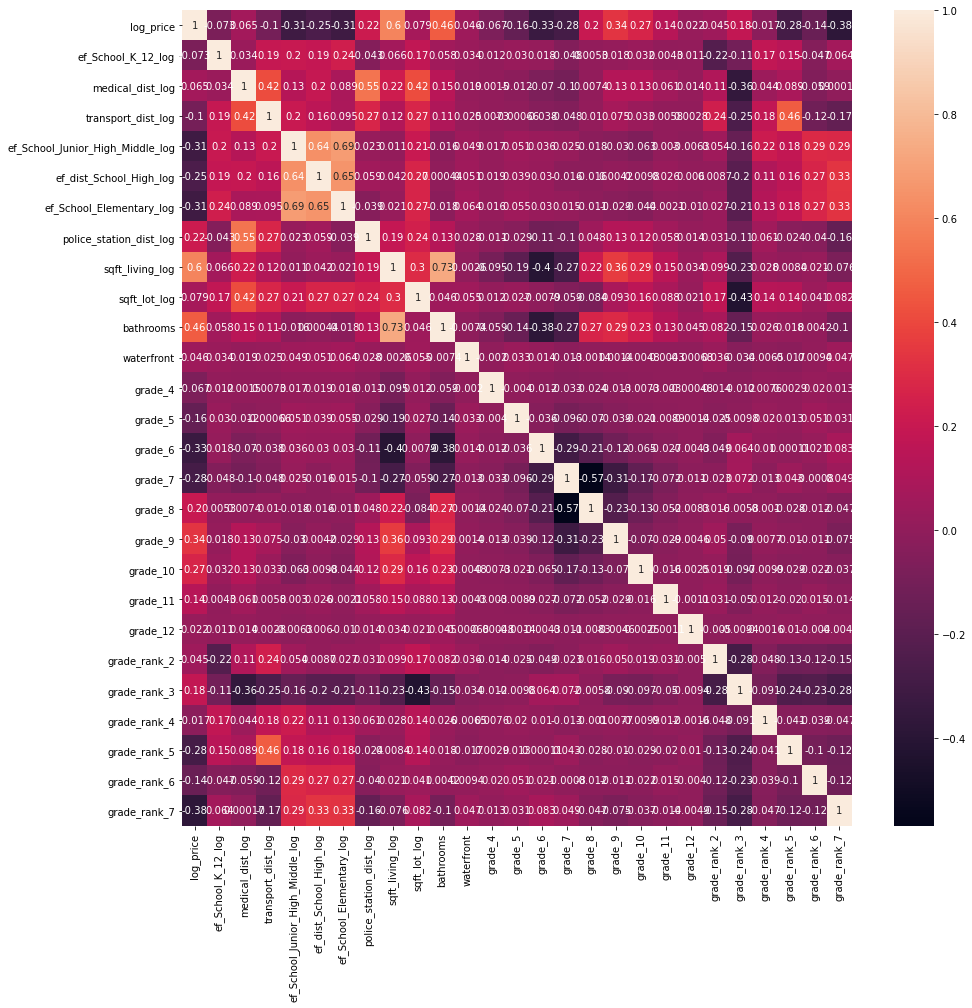

In [98]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model6.corr(),annot=True)

In [99]:
correlation(df_model6)

Empty DataFrame
Columns: [cc]
Index: []

In [100]:
train, test = train_test_split(df_model6)
print(len(train), len(test))

13581 4528


In [101]:
outcome = 'log_price'
x_cols = list(df_model6.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model6 = ols(formula=formula, data=train).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1435.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:20:23   Log-Likelihood:                -10464.
No. Observations:               13581   AIC:                         2.098e+04
Df Residuals:                   13555   BIC:                         2.118e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0041      0.004      0.907      0.364      -0.005       0.013
ef_School_K_12_log                  -0.0742      0.005    -13.610      0.000      -0.085      -0.063
medical_dist_log                    -0.0857      0.007    -13.163      0.000      -0.099      -0.073
transport_dist_log                  -0.0573      0.006     -8.881      0.000      -0.070      -0.045
ef_School_Junior_High_Middle_log     0.0172      0.007      2.324      0.020       0.003       0.032
ef_dist_School_High_log              0.0517      0.007      7.744      0.000       0.039       0.065
ef_School_Elementary_log            -0.0436      0.007     -6.125      0.000      -0.058      -0.030
police_station_dist_log              0.0334      0.006      5.846      0.000       0.022       0.045
sqft_living_log                      0.4019      0.008     49.852      0.000       0.386       0.418
sqft_lot_log                         0.1052      0.006     17.632      0.000       0.093       0.117
bathrooms                           -0.0136      0.007     -1.902      0.057      -0.028       0.000
waterfront                           0.0729      0.005     15.338      0.000       0.064       0.082
grade_4                             -0.0233      0.004     -5.566      0.000      -0.032      -0.015
grade_5                             -0.0580      0.005    -12.881      0.000      -0.067      -0.049
grade_6                             -0.1307      0.005    -27.198      0.000      -0.140      -0.121
grade_7                             -0.0964      0.003    -30.215      0.000      -0.103      -0.090
grade_8                              0.0562      0.003     16.424      0.000       0.050       0.063
grade_9                              0.1371      0.004     30.922      0.000       0.128       0.146
grade_10                             0.1050      0.005     22.353      0.000       0.096       0.114
grade_11                             0.0666      0.005     13.770      0.000       0.057       0.076
grade_12                             0.0115      0.005      2.421      0.016       0.002       0.021
grade_rank_2                        -0.1856      0.007    -25.575      0.000      -0.200      -0.171
grade_rank_3                        -0.0200      0.008     -2.405      0.016      -0.036      -0.004
grade_rank_4                        -0.0754      0.005    -14.233      0.000      -0.086      -0.065
grade_rank_5                        -0.3630      0.008    -48.008      0.000      -0.378      -0.348
grade_rank_6                        -0.2885      0.008    -38.423      0.000      -0.303      -0.274
grade_rank_7                        -0.4431      0.008    -55.677      0.000      -0.459      -0.427
=====================================================

In [102]:
vif(train)

[('ef_School_K_12_log', 1.4632673498633397),
 ('medical_dist_log', 2.099871379985174),
 ('transport_dist_log', 2.0645162974776143),
 ('ef_School_Junior_High_Middle_log', 2.720966102747459),
 ('ef_dist_School_High_log', 2.2355186157912237),
 ('ef_School_Elementary_log', 2.514084477807988),
 ('police_station_dist_log', 1.6087285984785875),
 ('sqft_living_log', 3.2129697477322376),
 ('sqft_lot_log', 1.744359911344325),
 ('bathrooms', 2.4830463434808467),
 ('waterfront', 1.0144849339137472),
 ('grade_4', 530816.9461991863),
 ('grade_5', 4057100.236094134),
 ('grade_6', 28879371.982302617),
 ('grade_7', 80974156.57096851),
 ('grade_8', 67956494.61206016),
 ('grade_9', 32134301.20718622),
 ('grade_10', 11683269.038952867),
 ('grade_11', 1922155.3019454782),
 ('grade_12', 48328.00027405691),
 ('grade_rank_2', 2.6750043207906313),
 ('grade_rank_3', 3.431760533391779),
 ('grade_rank_4', 1.4421769946032506),
 ('grade_rank_5', 2.8011651830250828),
 ('grade_rank_6', 2.789366815705052),
 ('grade_ra

In [103]:
residuals = model6.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


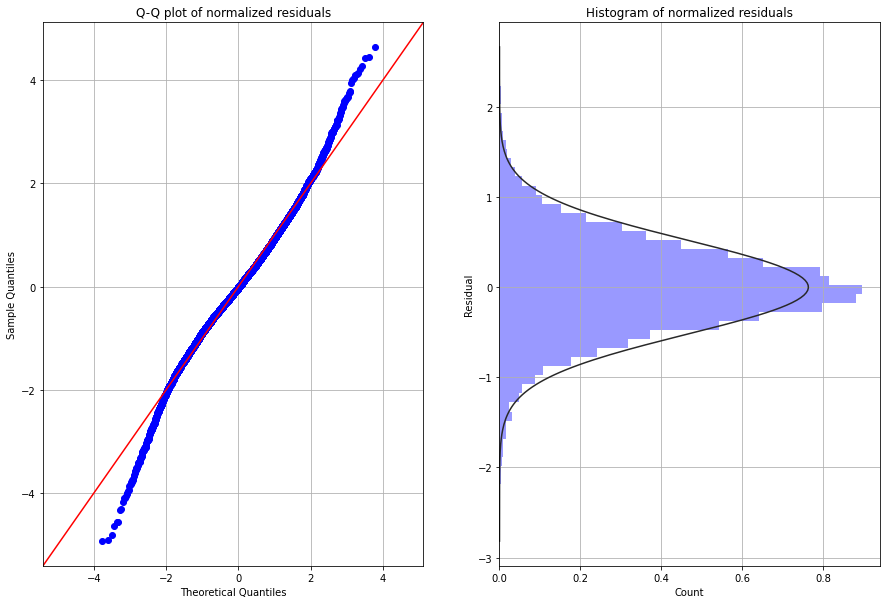

In [104]:
norm_dist_assumption(residuals)

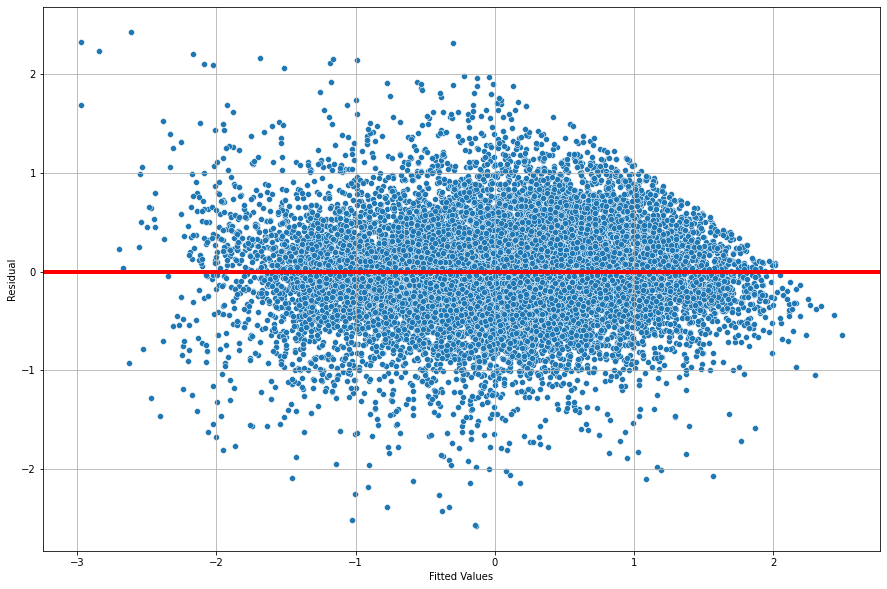

In [105]:
Heteroskedasticity_test(model6)

In [106]:
#Backward Elimination
y = df_model6['log_price']
cols = x_cols
X = df_model6[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12_log', 'medical_dist_log', 'transport_dist_log', 'ef_School_Junior_High_Middle_log', 'ef_dist_School_High_log', 'ef_School_Elementary_log', 'police_station_dist_log', 'sqft_living_log', 'sqft_lot_log', 'bathrooms', 'waterfront', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [107]:
predictors_be_6 = '+'.join(selected_features_BE_norm)
formula_be_6 = outcome + '~' + predictors_be_6
model_be_6 = ols(formula=formula_be_6, data=train).fit()
model_be_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1495.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:25:33   Log-Likelihood:                -10464.
No. Observations:               13581   AIC:                         2.098e+04
Df Residuals:                   13556   BIC:                         2.117e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0041      0.004      0.918      0.359      -0.005       0.013
ef_School_K_12_log                  -0.0742      0.005    -13.611      0.000      -0.085      -0.063
medical_dist_log                    -0.0857      0.007    -13.163      0.000      -0.099      -0.073
transport_dist_log                  -0.0573      0.006     -8.882      0.000      -0.070      -0.045
ef_School_Junior_High_Middle_log     0.0172      0.007      2.323      0.020       0.003       0.032
ef_dist_School_High_log              0.0517      0.007      7.746      0.000       0.039       0.065
ef_School_Elementary_log            -0.0436      0.007     -6.126      0.000      -0.058      -0.030
police_station_dist_log              0.0334      0.006      5.847      0.000       0.022       0.045
sqft_living_log                      0.4019      0.008     49.853      0.000       0.386       0.418
sqft_lot_log                         0.1052      0.006     17.634      0.000       0.093       0.117
bathrooms                           -0.0135      0.007     -1.900      0.057      -0.027       0.000
waterfront                           0.0729      0.005     15.338      0.000       0.064       0.082
grade_4                             -0.0539      0.005    -11.236      0.000      -0.063      -0.044
grade_5                             -0.1464      0.008    -18.233      0.000      -0.162      -0.131
grade_6                             -0.3773      0.019    -19.860      0.000      -0.415      -0.340
grade_7                             -0.5045      0.030    -16.877      0.000      -0.563      -0.446
grade_8                             -0.3176      0.027    -11.749      0.000      -0.371      -0.265
grade_9                             -0.1219      0.019     -6.470      0.000      -0.159      -0.085
grade_10                            -0.0503      0.012     -4.266      0.000      -0.073      -0.027
grade_rank_2                        -0.1856      0.007    -25.577      0.000      -0.200      -0.171
grade_rank_3                        -0.0200      0.008     -2.405      0.016      -0.036      -0.004
grade_rank_4                        -0.0754      0.005    -14.234      0.000      -0.086      -0.065
grade_rank_5                        -0.3630      0.008    -48.011      0.000      -0.378      -0.348
grade_rank_6                        -0.2885      0.008    -38.425      0.000      -0.303      -0.274
grade_rank_7                        -0.4431      0.008    -55.679      0.000      -0.459      -0.427
==============================================================================
Omnibus:                      359.132   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.126
Skew:             

In [108]:
vif(train[selected_features_BE_norm])

[('ef_School_K_12_log', 1.4633802451094233),
 ('medical_dist_log', 2.0998658088198927),
 ('transport_dist_log', 2.064486607378678),
 ('ef_School_Junior_High_Middle_log', 2.720887902908797),
 ('ef_dist_School_High_log', 2.23533539714617),
 ('ef_School_Elementary_log', 2.513835663480775),
 ('police_station_dist_log', 1.608715268096872),
 ('sqft_living_log', 3.212975516608107),
 ('sqft_lot_log', 1.744301333719605),
 ('bathrooms', 2.4826923652721353),
 ('waterfront', 1.0144813716123848),
 ('grade_4', 1.336934824020116),
 ('grade_5', 3.415681287854342),
 ('grade_6', 17.509894581748302),
 ('grade_7', 44.36523221743668),
 ('grade_8', 36.291783930740806),
 ('grade_9', 17.35475379258544),
 ('grade_10', 6.889899252102841),
 ('grade_rank_2', 2.6749930775625366),
 ('grade_rank_3', 3.4317249472678544),
 ('grade_rank_4', 1.4420872996349774),
 ('grade_rank_5', 2.800808689968029),
 ('grade_rank_6', 2.7893198482524),
 ('grade_rank_7', 3.144867416524565)]

# Model 7 
Quantile transformation

In [110]:
df_quantile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18109 entries, 0 to 18108
Data columns (total 31 columns):
price                           18109 non-null float64
School_Elementary               18109 non-null float64
School_K_12                     18109 non-null float64
School_Junior_High_Middle       18109 non-null float64
dist_School_High                18109 non-null float64
ef_School_K_12                  18109 non-null float64
ef_School_Junior_High_Middle    18109 non-null float64
ef_dist_School_High             18109 non-null float64
ef_School_Elementary            18109 non-null float64
police_station_dist             18109 non-null float64
medical_dist                    18109 non-null float64
transport_dist                  18109 non-null float64
sqft_living                     18109 non-null float64
sqft_lot                        18109 non-null float64
grade_4                         18109 non-null int64
grade_5                         18109 non-null int64
grade_6        

In [111]:
df_model7= df_quantile.drop(['School_Elementary','School_K_12','dist_School_High','School_Junior_High_Middle'], axis=1)

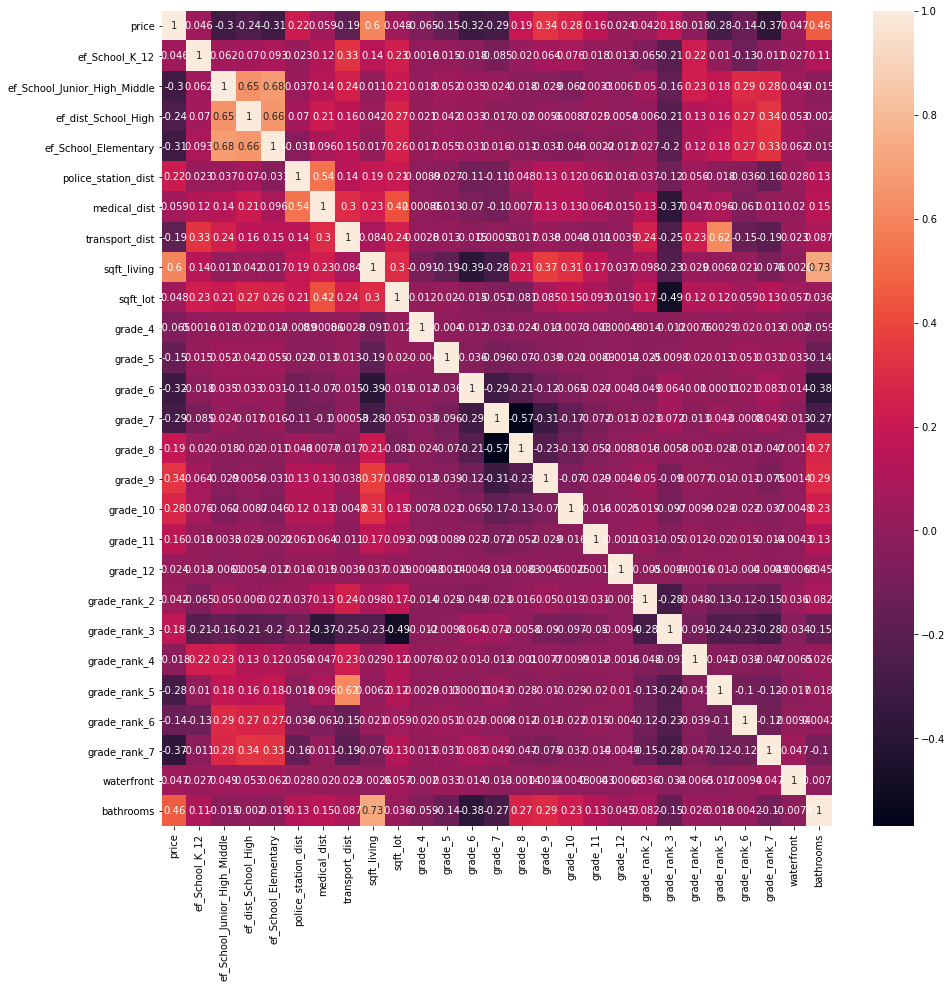

In [112]:
plt.figure(figsize=[15,15])
sns.heatmap(df_model7.corr(),annot=True)

In [113]:
train, test = train_test_split(df_model7)
print(len(train), len(test))

13581 4528


In [115]:
outcome = 'price'
x_cols = list(df_model7.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model7 = ols(formula=formula, data=train).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     1323.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:34:03   Log-Likelihood:                -10738.
No. Observations:               13581   AIC:                         2.153e+04
Df Residuals:                   13554   BIC:                         2.173e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.3688      0.536      2.554      0.011       0.318       2.419
ef_School_K_12                  -0.0217      0.003     -8.200      0.000      -0.027      -0.017
ef_School_Junior_High_Middle     0.0115      0.008      1.528      0.127      -0.003       0.026
ef_dist_School_High              0.0535      0.007      7.720      0.000       0.040       0.067
ef_School_Elementary            -0.0529      0.007     -7.277      0.000      -0.067      -0.039
police_station_dist              0.0379      0.006      6.534      0.000       0.027       0.049
medical_dist                    -0.0823      0.007    -12.465      0.000      -0.095      -0.069
transport_dist                  -0.0461      0.004    -12.407      0.000      -0.053      -0.039
sqft_living                      0.4034      0.008     48.544      0.000       0.387       0.420
sqft_lot                         0.0865      0.006     13.960      0.000       0.074       0.099
grade_4                         -1.6528      0.548     -3.018      0.003      -2.726      -0.579
grade_5                         -1.4301      0.536     -2.666      0.008      -2.481      -0.379
grade_6                         -1.2555      0.535     -2.347      0.019      -2.304      -0.207
grade_7                         -1.0360      0.535     -1.937      0.053      -2.085       0.013
grade_8                         -0.7427      0.535     -1.388      0.165      -1.792       0.306
grade_9                         -0.4024      0.536     -0.751      0.452      -1.452       0.647
grade_10                        -0.2408      0.536     -0.449      0.653      -1.292       0.810
grade_11                         0.2215      0.539      0.411      0.681      -0.834       1.277
grade_12                         0.1320      0.656      0.201      0.840      -1.153       1.417
grade_rank_2                    -0.4461      0.024    -18.255      0.000      -0.494      -0.398
grade_rank_3                    -0.0238      0.020     -1.200      0.230      -0.063       0.015
grade_rank_4                    -0.4261      0.048     -8.881      0.000      -0.520      -0.332
grade_rank_5                    -1.0405      0.034    -30.428      0.000      -1.108      -0.973
grade_rank_6                    -0.9818      0.029    -34.289      0.000      -1.038      -0.926
grade_rank_7                    -1.3153      0.026    -51.150      0.000      -1.366      -1.265
waterfront                       1.4287      0.086     16.560      0.000       1.260       1.598
bathrooms                       -0.0122      0.010     -1.180      0.238      -0.032       0.008
==============================================================================
Omnibus:                     1210.926   Durbin-Watson:                   1.992
Prob(Omnibus): 

In [116]:
vif(train)

[('ef_School_K_12', 2.1824084914104365),
 ('ef_School_Junior_High_Middle', 2.699571704614116),
 ('ef_dist_School_High', 2.301369586594157),
 ('ef_School_Elementary', 2.510836266741973),
 ('police_station_dist', 1.5993349902092768),
 ('medical_dist', 2.0832239235088985),
 ('transport_dist', 3.9874638425602327),
 ('sqft_living', 3.244621884478367),
 ('sqft_lot', 1.8354285694171848),
 ('grade_4', 1.0715653215979841),
 ('grade_5', 1.4819344322877843),
 ('grade_6', 4.544866822696506),
 ('grade_7', 16.67998223032691),
 ('grade_8', 12.041501195042846),
 ('grade_9', 5.373105759840378),
 ('grade_10', 2.620827379288989),
 ('grade_11', 1.364159311804874),
 ('grade_12', 1.0107743778481486),
 ('grade_rank_2', 3.6230950661177834),
 ('grade_rank_3', 6.5595780530100525),
 ('grade_rank_4', 1.5894463555476508),
 ('grade_rank_5', 5.308482096242724),
 ('grade_rank_6', 3.4118643037937835),
 ('grade_rank_7', 4.014257114371412),
 ('waterfront', 1.0177917717768217),
 ('bathrooms', 23.84173216908584)]

In [117]:
residuals = model7.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


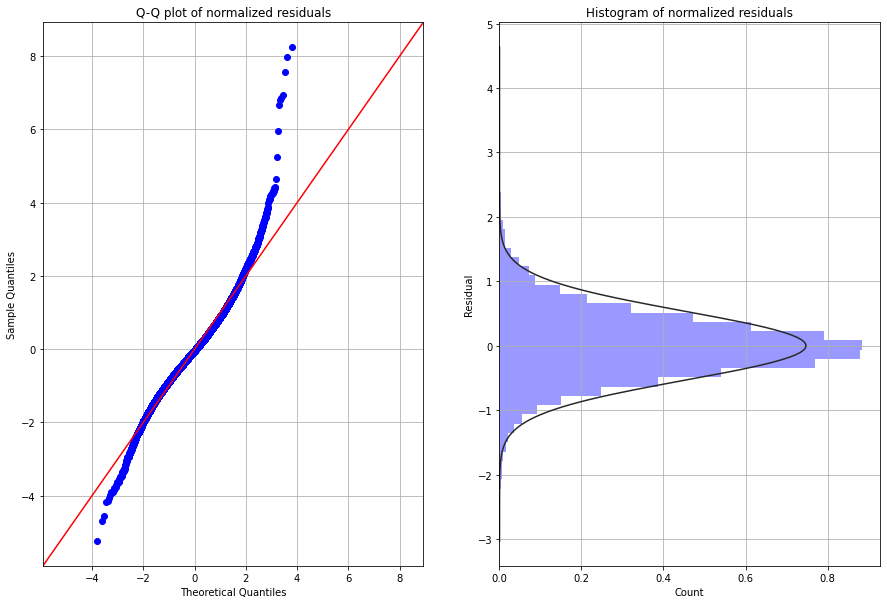

In [118]:
norm_dist_assumption(residuals)

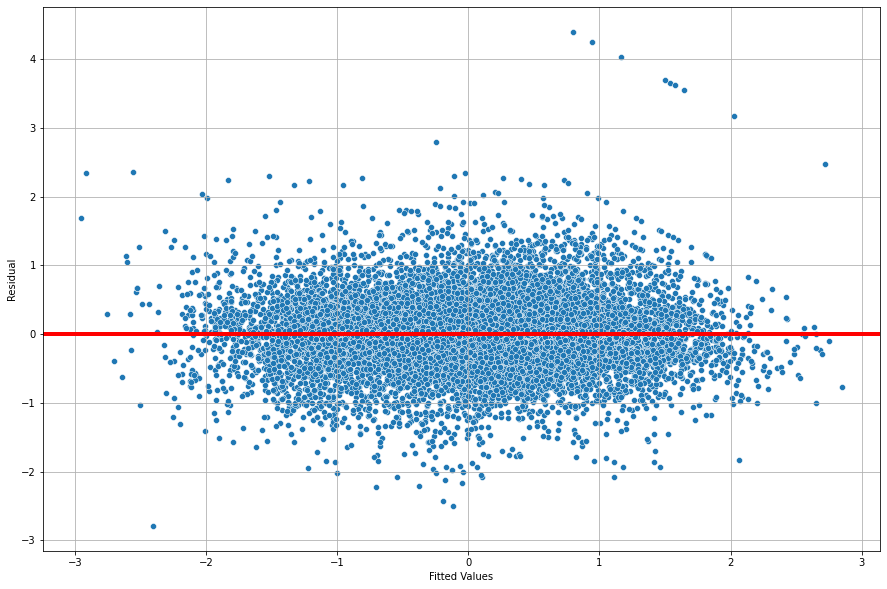

In [119]:
Heteroskedasticity_test(model7)

In [121]:
#Backward Elimination
y = df_model7['price']
cols = x_cols
X = df_model7[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

['ef_School_K_12', 'ef_School_Junior_High_Middle', 'ef_dist_School_High', 'ef_School_Elementary', 'police_station_dist', 'medical_dist', 'transport_dist', 'sqft_living', 'sqft_lot', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_rank_2', 'grade_rank_3', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7', 'waterfront', 'bathrooms']


C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [122]:
predictors_be_7 = '+'.join(selected_features_BE_norm)
formula_be_7 = outcome + '~' + predictors_be_7
model_be_7 = ols(formula=formula_be_7, data=train).fit()
model_be_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     1433.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:40:20   Log-Likelihood:                -10738.
No. Observations:               13581   AIC:                         2.153e+04
Df Residuals:                   13556   BIC:                         2.171e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.5859      0.064     24.683      0.000       1.460       1.712
ef_School_K_12                  -0.0218      0.003     -8.208      0.000      -0.027      -0.017
ef_School_Junior_High_Middle     0.0115      0.008      1.526      0.127      -0.003       0.026
ef_dist_School_High              0.0535      0.007      7.718      0.000       0.040       0.067
ef_School_Elementary            -0.0528      0.007     -7.271      0.000      -0.067      -0.039
police_station_dist              0.0379      0.006      6.539      0.000       0.027       0.049
medical_dist                    -0.0823      0.007    -12.462      0.000      -0.095      -0.069
transport_dist                  -0.0461      0.004    -12.407      0.000      -0.053      -0.039
sqft_living                      0.4035      0.008     48.633      0.000       0.387       0.420
sqft_lot                         0.0864      0.006     13.956      0.000       0.074       0.099
grade_4                         -1.8693      0.135    -13.856      0.000      -2.134      -1.605
grade_5                         -1.6468      0.074    -22.182      0.000      -1.792      -1.501
grade_6                         -1.4722      0.061    -24.125      0.000      -1.592      -1.353
grade_7                         -1.2529      0.058    -21.722      0.000      -1.366      -1.140
grade_8                         -0.9597      0.057    -16.895      0.000      -1.071      -0.848
grade_9                         -0.6195      0.057    -10.860      0.000      -0.731      -0.508
grade_10                        -0.4580      0.060     -7.639      0.000      -0.576      -0.340
grade_rank_2                    -0.4461      0.024    -18.257      0.000      -0.494      -0.398
grade_rank_3                    -0.0238      0.020     -1.202      0.229      -0.063       0.015
grade_rank_4                    -0.4260      0.048     -8.881      0.000      -0.520      -0.332
grade_rank_5                    -1.0408      0.034    -30.444      0.000      -1.108      -0.974
grade_rank_6                    -0.9819      0.029    -34.293      0.000      -1.038      -0.926
grade_rank_7                    -1.3153      0.026    -51.155      0.000      -1.366      -1.265
waterfront                       1.4286      0.086     16.560      0.000       1.260       1.598
bathrooms                       -0.0122      0.010     -1.181      0.238      -0.032       0.008
==============================================================================
Omnibus:                     1211.587   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4902.278
Skew:                           0.375   Prob(JB):                         0.00
Kurtosis:                       5.846   Cond. No.  

In [123]:
vif(train[selected_features_BE_norm])

[('ef_School_K_12', 2.1227265039458323),
 ('ef_School_Junior_High_Middle', 2.6724790684602837),
 ('ef_dist_School_High', 2.2971729004925416),
 ('ef_School_Elementary', 2.48825687470549),
 ('police_station_dist', 1.5846881454968789),
 ('medical_dist', 2.0662005657202704),
 ('transport_dist', 3.89486995927093),
 ('sqft_living', 3.231119769645476),
 ('sqft_lot', 1.7943883251711534),
 ('grade_4', 1.065617507923017),
 ('grade_5', 1.4230843725637086),
 ('grade_6', 4.020388687815781),
 ('grade_7', 13.489164862227996),
 ('grade_8', 9.437676142319566),
 ('grade_9', 4.2358422311932475),
 ('grade_10', 2.185531423315534),
 ('grade_rank_2', 3.4299799406762057),
 ('grade_rank_3', 6.071035412879752),
 ('grade_rank_4', 1.5605067297394692),
 ('grade_rank_5', 5.054081990148971),
 ('grade_rank_6', 3.237057909663474),
 ('grade_rank_7', 3.814804082285619),
 ('waterfront', 1.0177828750727016),
 ('bathrooms', 20.1944782649665)]

# Model 8
will remove transport_df and ef_School_K_12

In [124]:
df_model8= df_quantile.drop(['School_Elementary','School_K_12','dist_School_High','School_Junior_High_Middle','transport_dist', 'ef_School_K_12'], axis=1)

In [125]:
train, test = train_test_split(df_model8)
print(len(train), len(test))

13581 4528


In [126]:
outcome = 'price'
x_cols = list(df_model8.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model8 = ols(formula=formula, data=train).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     1450.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:50:18   Log-Likelihood:                -10869.
No. Observations:               13581   AIC:                         2.179e+04
Df Residuals:                   13557   BIC:                         2.197e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.5572      0.042     13.221      0.000       0.475       0.640
ef_School_Junior_High_Middle    -0.0111      0.008     -1.473      0.141      -0.026       0.004
ef_dist_School_High              0.0529      0.007      7.636      0.000       0.039       0.066
ef_School_Elementary            -0.0561      0.007     -7.879      0.000      -0.070      -0.042
police_station_dist              0.0433      0.006      7.537      0.000       0.032       0.055
medical_dist                    -0.0990      0.006    -15.603      0.000      -0.111      -0.087
sqft_living                      0.4107      0.008     48.920      0.000       0.394       0.427
sqft_lot                         0.0697      0.006     11.158      0.000       0.057       0.082
grade_4                         -0.7585      0.112     -6.757      0.000      -0.979      -0.538
grade_5                         -0.5699      0.053    -10.713      0.000      -0.674      -0.466
grade_6                         -0.4674      0.038    -12.284      0.000      -0.542      -0.393
grade_7                         -0.2433      0.035     -6.933      0.000      -0.312      -0.174
grade_8                          0.0426      0.035      1.209      0.227      -0.026       0.112
grade_9                          0.3823      0.037     10.356      0.000       0.310       0.455
grade_10                         0.5471      0.042     13.155      0.000       0.466       0.629
grade_11                         1.0871      0.062     17.417      0.000       0.965       1.209
grade_12                         0.5371      0.282      1.908      0.056      -0.015       1.089
grade_rank_2                    -0.4645      0.019    -24.530      0.000      -0.502      -0.427
grade_rank_3                     0.0121      0.017      0.699      0.484      -0.022       0.046
grade_rank_4                    -0.6506      0.043    -15.059      0.000      -0.735      -0.566
grade_rank_5                    -1.2162      0.023    -53.970      0.000      -1.260      -1.172
grade_rank_6                    -0.8767      0.025    -34.524      0.000      -0.926      -0.827
grade_rank_7                    -1.2383      0.024    -52.120      0.000      -1.285      -1.192
waterfront                       1.4116      0.087     16.218      0.000       1.241       1.582
bathrooms                       -0.0330      0.010     -3.162      0.002      -0.053      -0.013
==============================================================================
Omnibus:                     1156.908   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4672.948
Skew:                           0.350   Prob(JB):                         0.00
Kurtosis:                       5.787   Cond. No.  

In [127]:
vif(train)

[('ef_School_Junior_High_Middle', 2.6415292538667527),
 ('ef_dist_School_High', 2.2544355716991795),
 ('ef_School_Elementary', 2.356898896647274),
 ('police_station_dist', 1.5461272817755656),
 ('medical_dist', 1.8846336910234753),
 ('sqft_living', 3.2835214696026758),
 ('sqft_lot', 1.8146538573582973),
 ('grade_4', 1.0714073969669817),
 ('grade_5', 1.4255863660622397),
 ('grade_6', 4.105521382427021),
 ('grade_7', 14.448179209458955),
 ('grade_8', 10.834025131114581),
 ('grade_9', 4.831922325371452),
 ('grade_10', 2.420847669812835),
 ('grade_11', 1.3133286866650993),
 ('grade_12', 1.0194098650658943),
 ('grade_rank_2', 1.9044792649375295),
 ('grade_rank_3', 3.180083125171393),
 ('grade_rank_4', 1.3460728448982036),
 ('grade_rank_5', 2.059115107440423),
 ('grade_rank_6', 2.4469256208232046),
 ('grade_rank_7', 2.8512149305182937),
 ('waterfront', 1.0135326406119105),
 ('bathrooms', 2.545070755253)]

In [128]:
residuals = model8.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


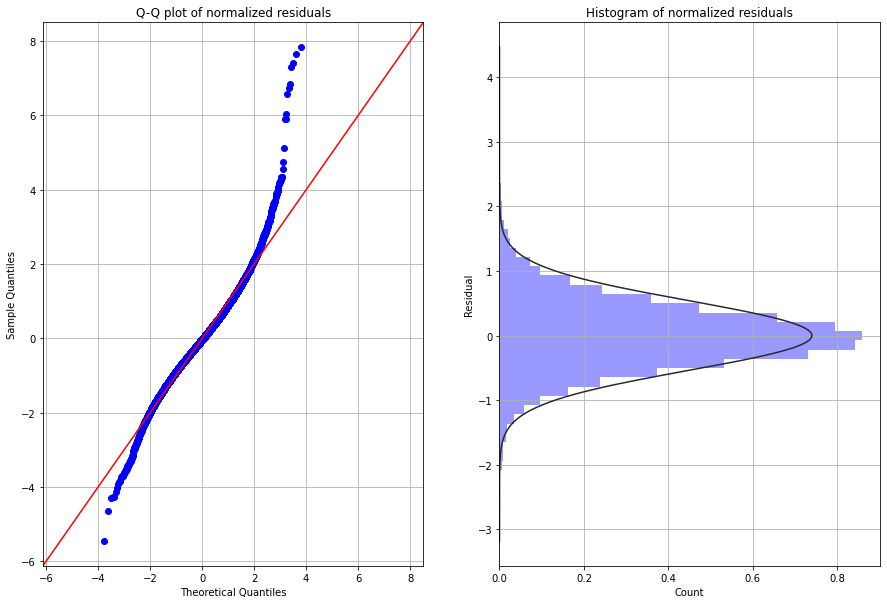

In [129]:
norm_dist_assumption(residuals)

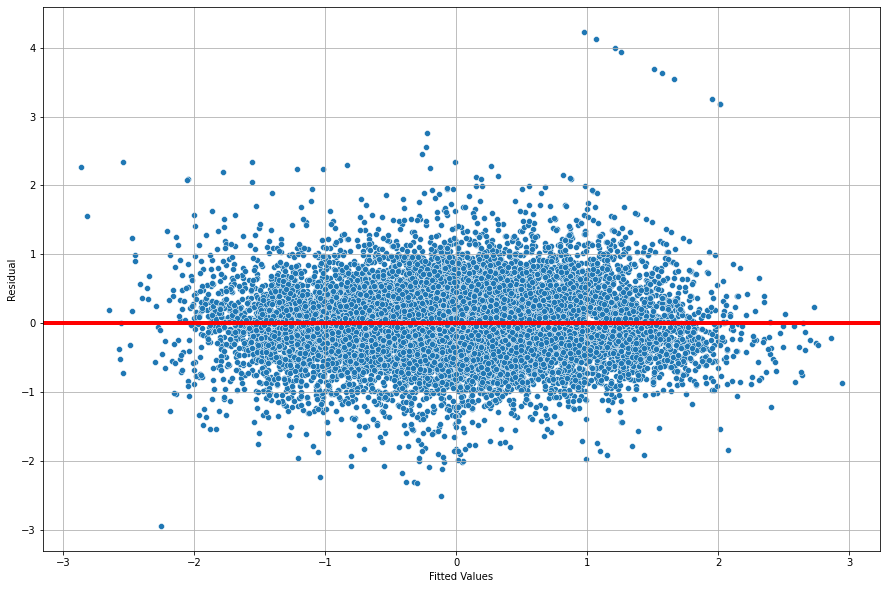

In [130]:
Heteroskedasticity_test(model8)

In [131]:
#Backward Elimination
y = df_model8['price']
cols = x_cols
X = df_model8[x_cols]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE_norm = cols
print(selected_features_BE_norm)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['ef_dist_School_High', 'ef_School_Elementary', 'police_station_dist', 'medical_dist', 'sqft_living', 'sqft_lot', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_11', 'grade_rank_2', 'grade_rank_4', 'grade_rank_5', 'grade_rank_6', 'grade_rank_7', 'waterfront', 'bathrooms']


In [132]:
predictors_be_8 = '+'.join(selected_features_BE_norm)
formula_be_8 = outcome + '~' + predictors_be_8
model_be_8 = ols(formula=formula_be_8, data=train).fit()
model_be_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     1667.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:55:20   Log-Likelihood:                -10870.
No. Observations:               13581   AIC:                         2.178e+04
Df Residuals:                   13560   BIC:                         2.194e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1161      0.035     31.524      0.000       1.047       1.186
ef_dist_School_High      0.0511      0.007      7.790      0.000       0.038       0.064
ef_School_Elementary    -0.0592      0.007     -9.038      0.000      -0.072      -0.046
police_station_dist      0.0425      0.006      7.434      0.000       0.031       0.054
medical_dist            -0.1005      0.006    -16.538      0.000      -0.112      -0.089
sqft_living              0.4106      0.008     48.921      0.000       0.394       0.427
sqft_lot                 0.0691      0.006     11.609      0.000       0.057       0.081
grade_4                 -1.3070      0.123    -10.599      0.000      -1.549      -1.065
grade_5                 -1.1180      0.054    -20.600      0.000      -1.224      -1.012
grade_6                 -1.0144      0.034    -29.588      0.000      -1.082      -0.947
grade_7                 -0.7906      0.028    -27.779      0.000      -0.846      -0.735
grade_8                 -0.5049      0.027    -18.604      0.000      -0.558      -0.452
grade_9                 -0.1652      0.028     -5.856      0.000      -0.220      -0.110
grade_11                 0.5401      0.062      8.769      0.000       0.419       0.661
grade_rank_2            -0.4756      0.015    -31.349      0.000      -0.505      -0.446
grade_rank_4            -0.6746      0.039    -17.224      0.000      -0.751      -0.598
grade_rank_5            -1.2299      0.018    -68.769      0.000      -1.265      -1.195
grade_rank_6            -0.8941      0.019    -46.708      0.000      -0.932      -0.857
grade_rank_7            -1.2535      0.018    -70.645      0.000      -1.288      -1.219
waterfront               1.4113      0.087     16.215      0.000       1.241       1.582
bathrooms               -0.0333      0.010     -3.213      0.001      -0.054      -0.013
==============================================================================
Omnibus:                     1153.018   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4649.003
Skew:                           0.349   Prob(JB):                         0.00
Kurtosis:                       5.780   Cond. No.                         66.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
# From this I will remove grade 7, bathrooms
vif(train[selected_features_BE_norm])

[('ef_dist_School_High', 2.022595192589237),
 ('ef_School_Elementary', 1.9812911342841906),
 ('police_station_dist', 1.5258390604636534),
 ('medical_dist', 1.7278450997773058),
 ('sqft_living', 3.1923178317765157),
 ('sqft_lot', 1.5958107920548503),
 ('grade_4', 1.0519728412451663),
 ('grade_5', 1.2549298794431285),
 ('grade_6', 2.530170942956182),
 ('grade_7', 6.463217773438731),
 ('grade_8', 4.804329767625422),
 ('grade_9', 2.394054531992673),
 ('grade_11', 1.1191018060577382),
 ('grade_rank_2', 1.40574637346929),
 ('grade_rank_4', 1.1237830693540851),
 ('grade_rank_5', 1.434577447002142),
 ('grade_rank_6', 1.5235088905424012),
 ('grade_rank_7', 1.8054844655493343),
 ('waterfront', 1.0162972948360356),
 ('bathrooms', 13.328890068614477)]

In [134]:
df_model8_modify= df_model8.drop(['ef_School_Junior_High_Middle','grade_7','bathrooms'], axis=1)

In [135]:
train, test = train_test_split(df_model8_modify)
print(len(train), len(test))

13581 4528


In [136]:
outcome = 'price'
x_cols = list(df_model8_modify.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model8_m = ols(formula=formula, data=train).fit()
model8_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     1585.
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:09:00   Log-Likelihood:                -10886.
No. Observations:               13581   AIC:                         2.182e+04
Df Residuals:                   13559   BIC:                         2.198e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2487      0.015     16.452      0.000       0.219       0.278
ef_dist_School_High      0.0453      0.007      6.677      0.000       0.032       0.059
ef_School_Elementary    -0.0593      0.007     -8.852      0.000      -0.072      -0.046
police_station_dist      0.0374      0.006      6.556      0.000       0.026       0.049
medical_dist            -0.0960      0.006    -15.261      0.000      -0.108      -0.084
sqft_living              0.3962      0.007     57.445      0.000       0.383       0.410
sqft_lot                 0.0810      0.006     13.540      0.000       0.069       0.093
grade_4                 -0.1208      0.136     -0.887      0.375      -0.388       0.146
grade_5                 -0.3799      0.045     -8.483      0.000      -0.468      -0.292
grade_6                 -0.2394      0.017    -13.728      0.000      -0.274      -0.205
grade_8                  0.2870      0.012     23.837      0.000       0.263       0.311
grade_9                  0.6367      0.018     34.911      0.000       0.601       0.672
grade_10                 0.7826      0.028     27.864      0.000       0.728       0.838
grade_11                 1.1979      0.061     19.643      0.000       1.078       1.317
grade_12                 0.5783      0.383      1.511      0.131      -0.172       1.328
grade_rank_2            -0.4861      0.018    -26.848      0.000      -0.522      -0.451
grade_rank_3             0.0192      0.017      1.160      0.246      -0.013       0.052
grade_rank_4            -0.7161      0.042    -17.094      0.000      -0.798      -0.634
grade_rank_5            -1.2116      0.021    -56.507      0.000      -1.254      -1.170
grade_rank_6            -0.8830      0.024    -37.180      0.000      -0.930      -0.836
grade_rank_7            -1.2267      0.022    -54.776      0.000      -1.271      -1.183
waterfront               1.2978      0.087     14.896      0.000       1.127       1.469
==============================================================================
Omnibus:                     1024.137   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3552.376
Skew:                           0.343   Prob(JB):                         0.00
Kurtosis:                       5.410   Cond. No.                         125.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
vif(train)

[('ef_dist_School_High', 1.9759461361484754),
 ('ef_School_Elementary', 1.959376841101031),
 ('police_station_dist', 1.518315294223397),
 ('medical_dist', 1.7865298234552245),
 ('sqft_living', 2.163370227241439),
 ('sqft_lot', 1.6189316363973105),
 ('grade_4', 1.016778170991883),
 ('grade_5', 1.0866786168357598),
 ('grade_6', 1.390111096046897),
 ('grade_8', 1.6356695178524578),
 ('grade_9', 1.5181087029786962),
 ('grade_10', 1.2912929949602836),
 ('grade_11', 1.0811886334335128),
 ('grade_12', 1.004558617200707),
 ('grade_rank_2', 1.1801896652167203),
 ('grade_rank_3', 1.709295828354419),
 ('grade_rank_4', 1.068027393260413),
 ('grade_rank_5', 1.173339895910187),
 ('grade_rank_6', 1.2890569712908817),
 ('grade_rank_7', 1.437533817386283),
 ('waterfront', 1.0159351624369575)]

In [138]:
residuals = model8_m.resid

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


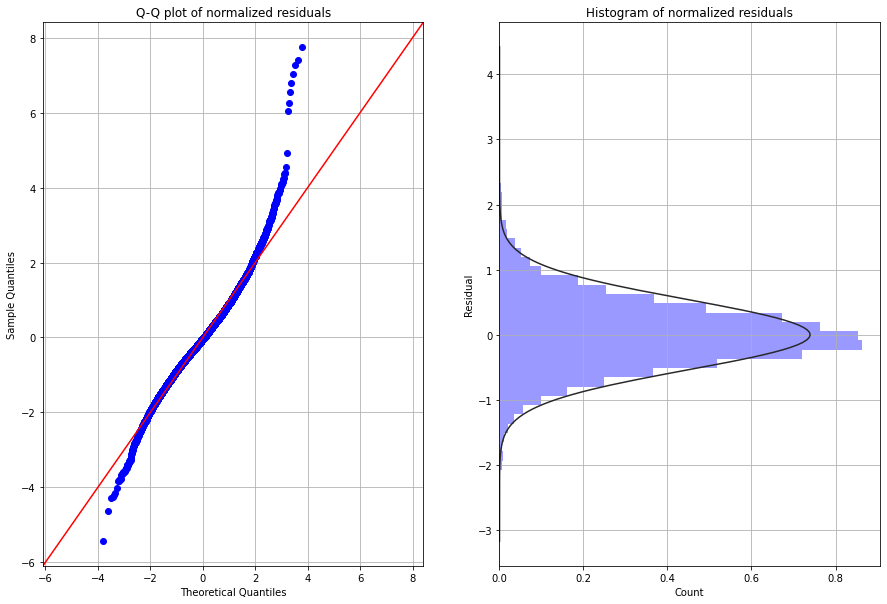

In [139]:
norm_dist_assumption(residuals)

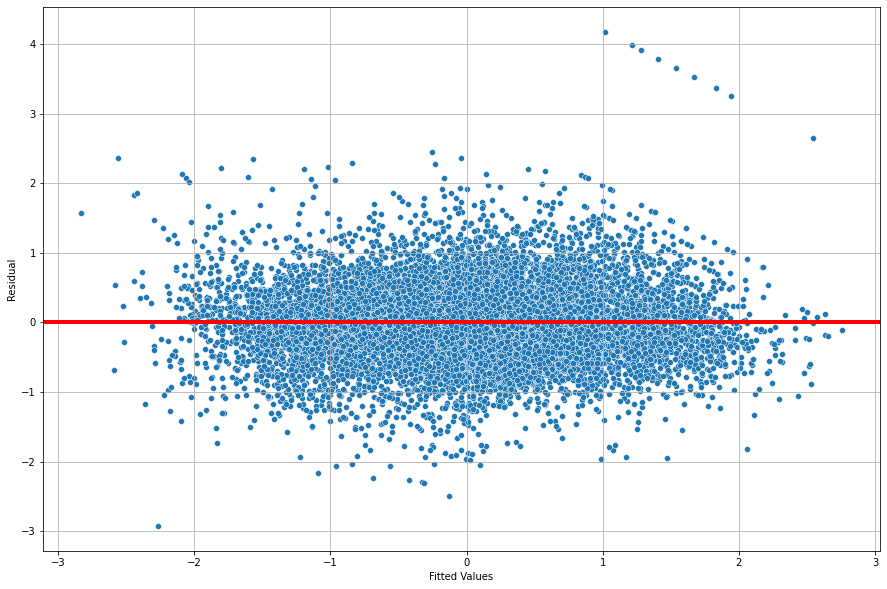

In [140]:
Heteroskedasticity_test(model8_m)